# Subspace Inference of Bayesian Deep Learning and Sensitivity Testing

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi (Queena) Zhou

## Contents
1. Introduction
2. Technical content
    <br>2.1. High level
    <br>2.2. Details
3. Our Extension: Sensitivity Testing
4. Experiments
    <br>4.1. Code structure
    <br>4.2. Toy example
    <br>---- 4.2.1 Subspace Construction
    <br>---- 4.2.2 Subspace Inference
    <br>---- 4.2.3 Conclusion and Discussion
    <br>4.3. Extension
    <br>---- 4.3.1. Subspace VS Full Parameter Space
    <br>---- 4.3.2. Deep and Wide Structure
    <br>---- 4.3.3. Different initialization
    <br>---- 4.3.4. PCA variant
5. Future Work

## 1. Introduction
Our paper’s name is [Subspace Inference for Bayesian Deep Learning](https://arxiv.org/abs/1907.07504).  In this paper, it is trying to solve the following problem:  Bayesian inference has been a  useful  tool  to  perform  inference  with  neural  networks,  but  using  it  could be  challenging  when  the  neural  network  becomes  deeper  or  larger,  since  the parameter space becomes extremely high dimensional. The associated posterior distribution would have a rough surface, just like in the image below. It shows a simple 1-layer-5-unit neural network has already demonstrated a rough landscape, so it's hard to perform inference directly. ![posterior distribution](https://i.ibb.co/54NkMcT/zigzag.png)

Common methods can easily fall into local minima or take a long time to converge. How could we still use Bayesian methods to perform inference with those deep neural networks?  This problem is important in the modern world, because all the neural networks are built to be deeper and wider.  These models can have almost perfect predictions, but other than predictions,  we care about the inference on the parameters in them as well.  We want to know what the predictive distribution and uncertaintylook like.  This paper addresses this issue by an approach, in which the original parameter space is reduced into a low-dimensional subspace by some methods, and  then  we  can  perform  Bayesian  inference  over  the  parameters  within  the subspace.

This paper lists some related work for which the main points are summarized here:
1. The SWAG method can define a distribution over low-dimensional subspace, given the first principal components of the stochastic gradient descent (SGD) iterates.  It's useful in getting a Gaussian posterior over neural network weights.
2. Bayesian  inference  could  be  applied  to  probabilistic  PCA  using  projected methods for latent variable models.
3. Various ways have been proposed to perform variational inference in a low-dimensional subspace for Bayesian neural network.
4. There  is  a  theoretical  guarantee  for  Bayesian  inference  in  the  setting  of constrained posteriors.  The constraints (e.g.  the subspace) can be chosen before or after performing unconstrained inference via SGD.
5. Other approaches have tried to perform efficient inference by operating solely in data space, rather than in parameter space.

The gap in literature that the paper is trying to fill is that no one previously has proposed the method to approximate Bayesian inference in low-dimensional subspace of the weight space for high-dimensional neural networks.  Therefore, this  method  is  the  authors'  main  contribution  and  they  named  it  `Subspace Inference` (SI).



## 2. Technical content

### 2.1. High level

On the high level, their proposed Bayesian subspace inference algorithm contains three steps:  1) construct subspace, 2) posterior inference within subspace, 3)  form  a  Bayesian  model  average.   During  the  subspace  construction  stage, they  use  three  subspaces  including  random  subspace,  the  subspace  spanned by the first few PCA components of the SGD trajectory, and curve subspace. They then propose using various methods including the MCMC methods such as Hamiltonian Monte Carlo (HMC) or elliptical slice sampling (ESS) for the approximate inference procedures. This Subspace Inference shows great performance in terms of accuracy and likelihood and thus implies the low-dimension subspaces contains a rich representations of full space.

### 2.2. Details

In [3]:
from IPython.display import display, Math, Latex

#### Overview
We perform inference in a K-dimensional subspace $\mathcal{S}$ defined by 
\begin{aligned}
\mathcal{S} &= \{w|w = \hat{w} + z_1v_1 + \ldots + z_Kv_K\} \\
&= \{w|w = \hat{w} + Pz\}.
\end{aligned}
With a fixed $\hat{w}$ and projection matrix $P$, over which we perform inference, the free parameters of the model are now simply $z\in\mathbb{R}^K$. The new model thus has the likelihood function $$p(\mathcal{D}|z) = p_\mathcal{M}(\mathcal{D}|w = \hat{w} + Pz).$$ We can then perform Bayesian model averaging on new test data points $\mathcal{D}^*$, using the posterior over the parameters in the subspace:
\begin{aligned}
p(\mathcal{D}^*|\mathcal{D}) &= \int p_\mathcal{M}(\mathcal{D}^*|\tilde{w} = \hat{w} + Pz)p(z|\mathcal{D})\text{d}z \\
&\approx \frac{1}{J}\sum_{j=1}^Jp_\mathcal{M}(\mathcal{D}^*|\tilde{w} = \hat{w}+P\tilde{z}_j),\quad \tilde{z}_j \sim p(z|\mathcal{D}).
\end{aligned}





#### Subspace Construction
In this section we will show various ways to construct the subspace $\mathcal{S}$. <br>

**1. Random Subspaces**

The basis $P$ is constructed by randomly drawing $K$ vectors $v_1, \ldots, v_K \sim \mathcal{N}(0, I_p)$ in th weight space. We then rescale them to have norm 1. The shift vector is generated using the weights of a network pre-trained with stochastic weight averaging (SWA): $\hat{w} = w_{\text{SWA}}$. In particular, we run SGD with a high constant learning rate from a pre-trained solution, and form the average $w_{\text{SWA}} = \frac{1}{T}\sum_i w_i$ from the SGD iterates $w_i$. <br>

**2. PCA of the SGD Trajectory**

In the method of PCA, it also uses the $w_{\text{SWA}}$ which is used in random subspace but records additional information during the SGD trajectory. Specifically, we also run SGD with a high constant learning rate from a pre-trained soution, but at each fixed-length interval $c$, we capture the snapshots $w_i$ and use it to update two information:
- parameter $w_{\text{SWA}}$: the weighted average of previous $w_{\text{SWA}}$ and this $w_i$. (the same in random subspace)
- deviation vector $a_i$: which equals $w_{\text{SWA}}$ - $w_i$. (only in PCA subspace)

Then given the amount of memory we have, we come up with an number $M$, and we store the last $M$ deviation vector in a single deviation matrix $A$. We then run PCA based on randomized SVD on the matrix $A$ and  use the first $K$ principal component $v_1, \ldots, v_K$ to define the subspace.

**3. Curve Subspaces**

In this method, we find paths of near-constant low loss in the weight space between converged SGD solutions starting from different random initializations. Let $w_0, w_1$ be two sets of weights corresponding to the same neural network. Moreover, let $\phi_\theta: [0,1] \rightarrow \mathbb{R}^d$ be a continuous piecewise smooth parametric curve, with parameters $\theta$, such that $\phi_\theta(0) = w_0, \phi_\theta(1) = w_1$. To find a path of high accuracy between $w_0, w_1$, we propose to find parameters $\theta$ that minimize the expectation over a uniform distribution on the curve, $\hat{l}(\theta)$:
\begin{aligned}
\hat{l}(\theta) &= \frac{\int \mathcal{L}(\phi_\theta)\text{d}\phi_\theta}{\int\text{d}\phi_\theta} = \frac{\int_0^1\mathcal{L}(\phi_\theta(t))\|\phi_\theta^{'}(t)\|\text{d}t}{\int_0^1 \|\phi_\theta^{'}(t)\|\text{d}t} \\
&= \int_0^1 \mathcal{L}(\phi_\theta(t))q_\theta(t)\text{d}t = \mathbb{E}_{t\sim q_\theta(t)}\left[\mathcal{L}(\phi_\theta(t))\right],
\end{aligned}
where the distribution $q_\theta(t)$ on $t\in[0, 1]$ is defined as $q_\theta(t) := \|\phi_\theta^{'}(t)\|\cdot\left(\int_0^1 \|\phi_\theta^{'}(t)\|\text{d}t\right)^{-1}.$ Note that stochastic gradients of $\theta$ are generally intractable since $q_\theta(t)$ depends on $\theta$. Therefore we will use a more computationally tractable loss:
$$
l(\theta) = \int_0^1 \mathcal{L}(\phi_\theta(t))\text{d}t = \mathbb{E}_{t\sim U(0,1)}\mathcal{L}(\phi_\theta(t)).
$$
To minimize $l(\theta)$, at each iteration we sample $\tilde{t}$ from the unifrom distribution $U(0,1)$ and make a gradient step for $\theta$ with respect to the loss $\mathcal{L}(\phi_\theta(\tilde{t}))$. This way we can get unbiased estimates of the gradient of $l(\theta)$:
$$
\nabla_\theta\mathcal{L}(\phi_\theta(\tilde{t})) = \mathbb{E}_{t\sim U(0,1)} \nabla_\theta \mathcal{L}(\phi_\theta(t)) = \nabla_\theta \mathbb{E}_{t\sim U(0,1)} \mathcal{L}(\phi_\theta(t)) = \nabla_\theta l(\theta).
$$
Then we can perform gradient descent on $\theta$ to obtain the optimal curve.


In this work we employ the **Polygonal chain**. The trained weights $w_0$ and $w_1$ serve as the endpoints of the chain and the bends of the chain are the parameters $\theta$ of the curve parametrization. We only consider the simplest case of a chain with one bend $\theta$. Then
$$
\phi_\theta = \begin{cases} 2(t\theta + (0.5-t)w_0), & 0 \leq t \leq 0.5 \\
2((t-0.5)w_1 + (1-t)\theta), & 0.5 < t \leq 1. \end{cases}
$$

### Experiments

The authors of the paper evaluate subspace inference by combining the three subspaces with different approximate posterior inference methods. They first compare the performance of each combination on their data and show the comparison visually by drawing the predictive distribution. From the visualization plots on their data, they find that all the inference methods would work with the random and PCA subspace, but since the curve subspace has a more complex shaped posterior, variational methods do not produce reasonable fits. The plots also show that the random subspace does not allow growing uncertainty when farther away from the data, whereas the curve subspace is the best to adapt uncertainty. 


They essentially want to prove subspace inference can do just as well as performing inference in the original parameter space, or even better, so they visualize the predictive distributions for simple variational inference applied in the original parameter space. From the visualization, they see the SWAG's predictive distribution is similar to the PCA subspace's one. However, variational inference tends to underfit data, and Gaussian process (GP) with an RBF kernel becomes underconfident when farther away from the neighborhood of data, meaning that uncertainty quickly blows up. It's shown in this procedure that subspace inference might show even better results than original-space inference.


They then compare the subspace inference methods on UCI regression tasks to a variety of methods for approximate Bayesian inference with neural networks. This time the comparison is done quantitatively and they compute Gaussian test likelihood as the metric. They show that subspace inference achieves as good or better test log-likelihoods compared to SGD and SWAG on the original parameter space.


Next, they test the proposed method on state-of-the-art convolutional networks on CIFAR datasets. They report the accuracy and negative log-likelihood for each of the subspaces. Going from random, to PCA, to curve subspaces provides progressively better results. It's also shown that subspace inference is competitive with SWAG and consistently outperforms most of the other baselines, including MC-dropout.



### Evaluation

It's interesting to see that subspaces can be chosen to contain a diverse variety of representations, corresponding to different high quality predictions. It's also surprising to see that subspace inference can outperform inference in original parameter space sometimes. This work is definitely technically sound as it provides an easier yet promising way for inference with neural networks. The proposed method is practical to use on real data, as people using it only need to train a neural network, find the lower-dimension subspace, perform a much easier inference in the subspace, and convert back to the original parameter space. The experimental section contains enough evidence to support the claims. 

## 3. Our Extension: Sensitivity Testing


Now, we are going to follow the guidance of this paper to conduct our own experiments, to test whether the subspace inference method can be generalized onto a smaller dataset and various hypotheses that are related to the network structure and subspace construction. In our project, we are interested in the stability of this Subspace Inference framework. More specifically, we test its sensitivity from two aspects:
1. How does subspace method improve the Bayesian deep neural network in terms of efficiency and uncertainty estimation?
2. Does it display similar performance over deep and wide neural network? 
3. Is it sensitive to the initial value to start with?

We also expand PCA subspace with different "SWA" methods: instead of update the deviation matrix every T steps , we choose to update the deviation matrix with the smallest deviations. 

For more detailed information about our extension, please see **4.3.**

## 4. Experiments
### 4.1. Code structure

The following is our code structure: ![code structure](https://i.ibb.co/ggmrRfY/2.png) We use the unified structure of `model`, `subspace` and `inference` class, and enable the same API usage. 

We store all the code on our GitHub repository, linked [here](https://github.com/YimingXu1213/am207_Project/tree/master/src).

### 4.2. Toy example 



We first train a simple neural network with 1 layer and 5 units. The data we use is taken from AM207 HW7.

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np
import pandas as pd
import time
from Inference import Inference
from Subspace import Subspace
from model import Model
import CurveSubspace as curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D
from util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.1166805377315; gradient mag: 164.73210946091575
Iteration 100 lower bound 52.86436046756695; gradient mag: 56.95458639088457
Iteration 200 lower bound 49.42633385370295; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.73326189562314; gradient mag: 18.311751879565836
Iteration 400 lower bound 46.647745693540806; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.88691542805831; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.97792508592485; gradient mag: 20.354176994190937
Iteration 900 lower bound 24.278363637665734; gradient mag: 18.77912591689822
Iteration 1000 lower bound 22.029867169404948; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866593
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.092044

The fitted model's prediction is shown below.

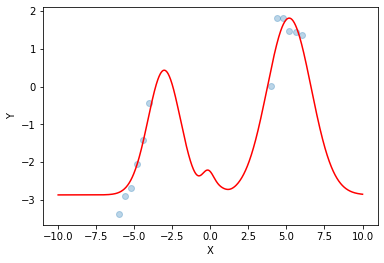

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y');

#### 4.2.1 Subspace Construction

Here we demonstrate how we use our code to construct the subspaces. We also want to compare the time duration to construct each of them.

**Random Subspace.**

In [5]:
begin=time.time()
my_subspace_rand = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace_rand.collect_vector(X=x, y=y)
end=time.time()
print('It costs {:.2f} sec to calculate Random Subspace'.format(end-begin) )

It costs 6.71 sec to calculate Random Subspace


**PCA Subspace.**

In [6]:
begin=time.time()
my_subspace_pca = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace_pca.collect_vector(X=x, y=y)
end=time.time()
print('It costs {:.2f} sec to calculate PCA Subspace'.format(end-begin) )

It costs 7.13 sec to calculate PCA Subspace


**Curve Subspace.**

In [7]:
def CurveNetGen(w0, w1):
    return curve.CurveNet(1, width, hidden_layers, w0, w1)

# for training the mid-points
params_curve = {'sample_size': 500}
net = curve.BaseNet(1, width, hidden_layers)

optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.MSELoss()

dataset = TensorDataset(torch.Tensor(x.reshape(-1, 1)), torch.Tensor(y))
loader = DataLoader(dataset, batch_size=64, shuffle = True)

# for training the two endpoints
#params_base = {'epochs': 1000}
params_base = params
begin=time.time()
my_subspace_curve = Subspace.create(subspace_type="curve", net = net, params_base = params_base, nn = my_nn, 
                              X = x, y = y, loader = loader, criterion = criterion, 
                              curve_net_gen = CurveNetGen, params_curve = params_curve)
my_subspace_curve.collect_vector(epochs = 200, callback = 20, restart = False)
end=time.time()

[epoch 1] loss: 0.234
[epoch 21] loss: 0.229
[epoch 41] loss: 0.228
[epoch 61] loss: 0.226
[epoch 81] loss: 0.225
[epoch 101] loss: 0.224
[epoch 121] loss: 0.217
[epoch 141] loss: 0.222
[epoch 161] loss: 0.219
[epoch 181] loss: 0.219


In [8]:
print('It costs {:.2f} sec to calculate Curve Subspace'.format(end-begin) )

It costs 122.12 sec to calculate Curve Subspace


It's not surprising that the curve subspace takes the longest time to construct, more than 20 times than the PCA and random subspaces.

#### 4.2.2 Subspace Inference

After constructing the subspaces, we conduct both **Hamiltonian Monte Carlo (HMC)** and **Bayes By Backprop (BBB)** inference methods to test the performance of subspace inference. 

To make the convergence of HMC sampler faster, we have used many tricks such as automatically adjust epislon in leap-frog step to tune the acceptance rate to an acceptable value. More detailed information of the tricks we have used in tuning the HMC sampler could be found through https://mc-stan.org/docs/2_20/reference-manual/hmc-algorithm-parameters.html.

To better compare the performance between different subspaces, we define the functions for calculating the posterior predictive log likelihood and plotting the posterior log-density surfaces.

In [9]:
output_noise = 0.5**2
def log_likelihood(y_actual, y_pred):
    return -0.5 * np.log(2 * np.pi * output_noise) - 0.5 * np.mean(((y_actual - y_pred)**2).sum(axis = 1)) / output_noise

In [10]:
def plot_posterior_likelihood(my_inference,name,zx_range=[-0.2,0.2], zy_range=[-0.2,0.2]):
    zx=np.linspace(zx_range[0],zx_range[1],10)
    zy=np.linspace(zy_range[0],zy_range[1],10)
    zx,zy=np.meshgrid(zx,zy)
    z=np.array([zx,zy]).reshape(2,-1).T
    level = my_inference.get_posterior_likelihood(z=z,X=x,y=y).reshape(10,10)
    post_z=my_inference.get_posterior(50)
    post_level=my_inference.get_posterior_likelihood(z=post_z,X=x,y=y)
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(zx,zy,level,cmap='Reds', edgecolor='none')
    ax.scatter3D(post_z[:,0],post_z[:,1],post_level,label='chosed posterior z')
    plt.title('posterior log density ',fontsize=15)
    ax.set_xlabel('z 1')
    ax.set_ylabel('z 2')
    ax.set_zlabel('posterior log density')
    plt.legend(loc='lower left')
    ax1= fig.add_subplot(122)
    cs=ax1.contourf(zx, zy, level, levels=20, linewidths=1,cmap='Reds')
    ax1.scatter(post_z[:,0],post_z[:,1],label='chosed posterior z',s=5)
    fig.colorbar(cs, ax=ax1)
    plt.xlabel('z 1')
    plt.ylabel('z 2')
    plt.title('posterior log density ',fontsize=15)
    plt.legend()
    plt.suptitle(name, fontsize=20)

**----`HMC Inference`----**

**Random Subspace.**

In [21]:
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [22]:
hmc_tune_params={'step_size':1e-3,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [23]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.001
HMC 400: accept rate of 100.0 with step size 0.0025000000000000005
HMC 600: accept rate of 99.66666666666667 with step size 0.004000000000000001
HMC 800: accept rate of 99.25 with step size 0.005500000000000001
HMC 1000: accept rate of 99.2 with step size 0.00688375431485499
HMC 1200: accept rate of 98.91666666666666 with step size 0.008376133451613426
HMC 1400: accept rate of 98.85714285714286 with step size 0.009864375455275605
HMC 1600: accept rate of 97.9375 with step size 0.011276223052299278
HMC 1800: accept rate of 97.22222222222221 with step size 0.012776223052299278
HMC 2000: accept rate of 96.45 with step size 0.013601889822525744
HMC 2200: accept rate of 95.31818181818181 with step size 0.014353421273885288
HMC 2400: accept rate of 93.83333333333333 with step size 0.01585342127388529
HMC 2600: accept rate of 93.42307692307692 with step size 0.014921166153919724
HMC 2800: accept rate of 91.89285714285714 with step size 0.0156

In [24]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 10.63 min


In [25]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

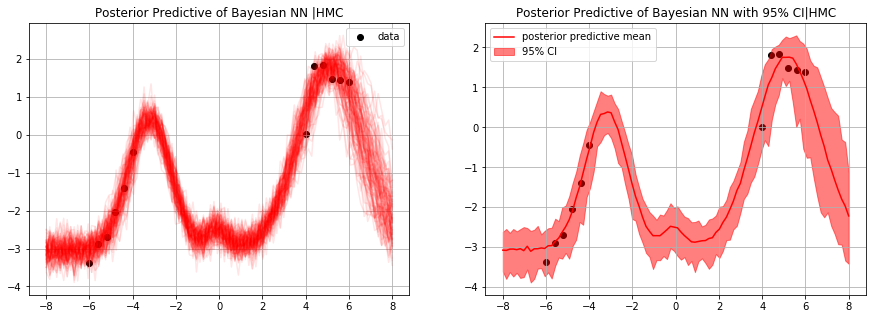

In [26]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

Check the convergence of the HMC sampler:

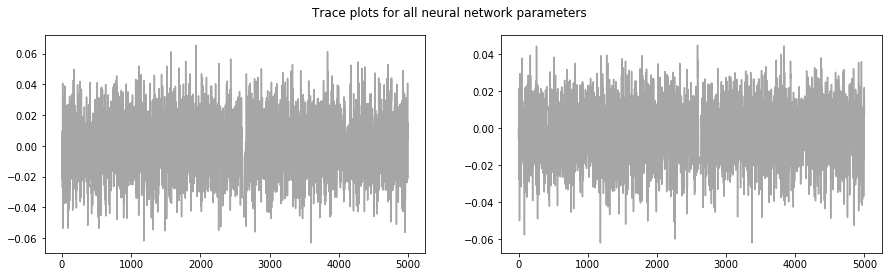

In [27]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

Calculate the posterior predictive log-likelihood of the observed data:

In [28]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_random = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_random))

The Posterior Predictive Log likelihood of the observed data is -3.7741


Plot the posterior log-density surfaces:

/Users/susanaxu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: linewidths is ignored by contourf


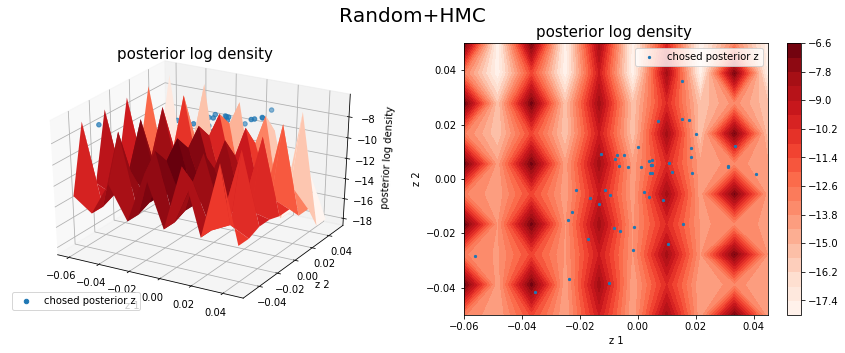

In [39]:
plot_posterior_likelihood(my_inference=my_inference, name='Random+HMC',zx_range=[-0.06,0.045], zy_range=[-0.05,0.05])

On the posterior log-density surface above, the deeper the red is, the higher the log density, the better the performance is. Notes especially from the right plot, the blue points we chose as posterior z lies closely near the local highest pointest but not the global ones.

**PCA Subspace.**

In [40]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [41]:
hmc_tune_params={'step_size':5e-2,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

In [42]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=5)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)


In [43]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.05
HMC 400: accept rate of 100.0 with step size 0.05149590628513469
HMC 600: accept rate of 100.0 with step size 0.05299590628513469
HMC 800: accept rate of 100.0 with step size 0.05449448304423065
HMC 1000: accept rate of 99.9 with step size 0.05599448304423065
HMC 1200: accept rate of 99.91666666666667 with step size 0.057493318828562366
HMC 1400: accept rate of 99.92857142857143 with step size 0.05899331882856237
HMC 1600: accept rate of 99.9375 with step size 0.060491307848387584
HMC 1800: accept rate of 99.94444444444444 with step size 0.061991307848387585
HMC 2000: accept rate of 99.95 with step size 0.06348952546446875
HMC 2200: accept rate of 99.95454545454545 with step size 0.06498566052361361
HMC 2400: accept rate of 99.95833333333334 with step size 0.06648323861727212
HMC 2600: accept rate of 99.96153846153845 with step size 0.067973645140047
HMC 2800: accept rate of 99.96428571428572 with step size 0.06947264431418144
HMC 3000:

In [44]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 8.92 min


In [45]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

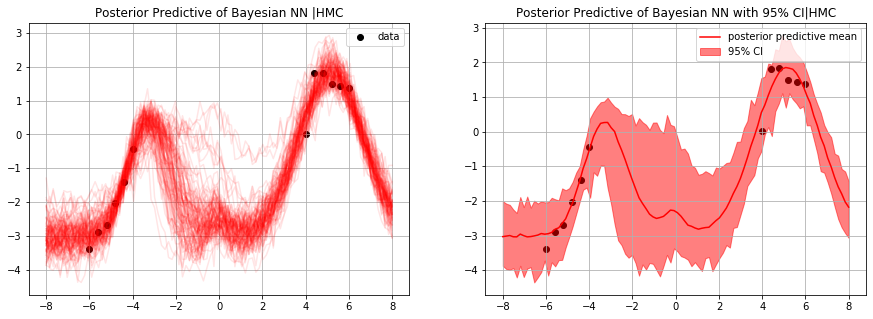

In [46]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
plt.show()

Check for the convergence of HMC sampler:

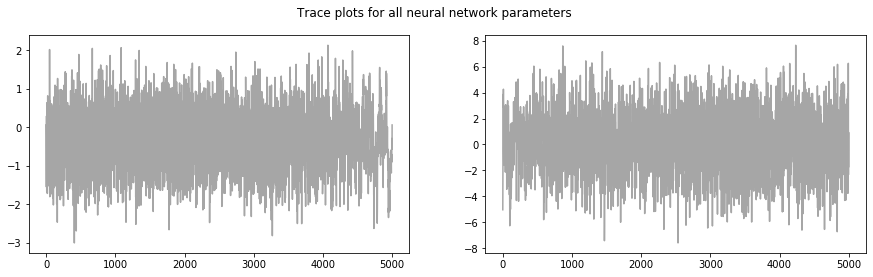

In [47]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [48]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca))

The Posterior Predictive Log likelihood of the observed data is -4.3521


/Users/susanaxu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: linewidths is ignored by contourf


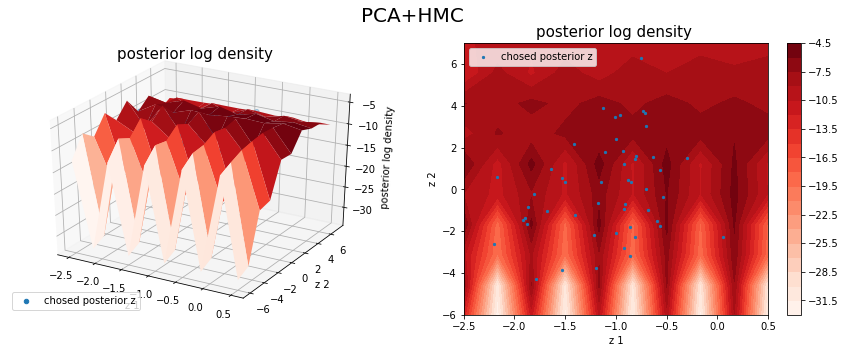

In [49]:
plot_posterior_likelihood(my_inference=my_inference, name='PCA+HMC',zx_range=[-2.5,0.5], zy_range=[-6,7])

From the plots above, we find that the data lies in the second - third highest area.

**Curve Subspace.**

In [13]:
#width = 5
#hidden_layers = 2
net = curve.BaseNet(1, width, hidden_layers)

optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.MSELoss()

dataset = TensorDataset(torch.Tensor(x.reshape(-1, 1)), torch.Tensor(y))
loader = DataLoader(dataset, batch_size=64, shuffle = True)

# for training the two endpoints
#params_base = {'epochs': 1000}
params_base = params

In [14]:
def CurveNetGen(w0, w1):
    return curve.CurveNet(1, width, hidden_layers, w0, w1)

# for training the mid-points
params_curve = {'sample_size': 500}

In [15]:
"""
my_subspace = Subspace.create(subspace_type="curve", net = net, loader = loader, params_base = params_base, 
                           optimizer = optimizer, criterion = criterion, 
                           curve_net_gen = CurveNetGen, params_curve = params_curve)
"""
my_subspace = Subspace.create(subspace_type="curve", net = net, params_base = params_base, nn = my_nn, 
                              X = x, y = y, loader = loader, criterion = criterion, 
                              curve_net_gen = CurveNetGen, params_curve = params_curve)

In [16]:
# change callback to control printing frequency (0 = no printing)
# epochs for training mid points
# restart: whether to get new endpoints or train on exisiting ones
my_subspace.collect_vector(epochs = 200, callback = 20, restart = False)
P, w = my_subspace.get_space()

[epoch 1] loss: 0.268
[epoch 21] loss: 0.265
[epoch 41] loss: 0.258
[epoch 61] loss: 0.256
[epoch 81] loss: 0.249
[epoch 101] loss: 0.245
[epoch 121] loss: 0.244
[epoch 141] loss: 0.240
[epoch 161] loss: 0.242
[epoch 181] loss: 0.236


In [17]:
hmc_tune_params={'step_size':1e-3,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

inference_hmc = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=inference_hmc.P, w_hat=inference_hmc.w_hat)

In [18]:
begin=time.time()
inference_hmc.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.001
HMC 400: accept rate of 100.0 with step size 0.002499917406334249
HMC 600: accept rate of 100.0 with step size 0.003999054570374719
HMC 800: accept rate of 100.0 with step size 0.005499054570374719
HMC 1000: accept rate of 99.8 with step size 0.00699341695076016
HMC 1200: accept rate of 99.83333333333333 with step size 0.00849341695076016
HMC 1400: accept rate of 99.85714285714286 with step size 0.009982262758778115
HMC 1600: accept rate of 99.875 with step size 0.011482262758778115
HMC 1800: accept rate of 99.8888888888889 with step size 0.012981192206028233
HMC 2000: accept rate of 99.9 with step size 0.014481192206028233
HMC 2200: accept rate of 99.86363636363636 with step size 0.015931128794729233
HMC 2400: accept rate of 99.875 with step size 0.0174275337972958
HMC 2600: accept rate of 99.8076923076923 with step size 0.018927533797295802
HMC 2800: accept rate of 99.75 with step size 0.020409801978950672
HMC 3000: accept rate of 99

In [19]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 6.42 min


In [20]:
# get posterior z
n_sample = 100
post_sample = inference_hmc.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_hmc = my_nn.forward(P=P, w_hat=w.reshape(-1, 1), z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, 1, size = (100, 100))

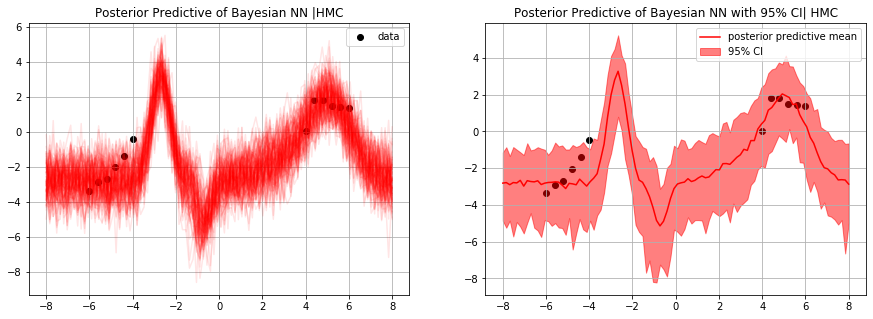

In [34]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_hmc[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_hmc.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_hmc, 0.25, axis=0), np.percentile(y_test_hmc, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI | HMC + curve')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

**----`BBB Inference`----**

**Random Subspace.**

In [44]:
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [45]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [46]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -193.31931666095662; gradient mag: 109.40731735896794
Iteration 200 lower bound -90.21775275531911; gradient mag: 17.326982603205924
Iteration 400 lower bound -72.52899957725451; gradient mag: 37.46440475553639
Iteration 600 lower bound -22.008031589691825; gradient mag: 20.087839629429897
Iteration 800 lower bound -13.047009067240277; gradient mag: 8.972712723928053
Iteration 1000 lower bound -10.599505649009837; gradient mag: 4.937316215296603
Iteration 1200 lower bound -9.659195724649464; gradient mag: 3.150948712222021
Iteration 1400 lower bound -9.252419102885161; gradient mag: 2.150793090538696
Iteration 1600 lower bound -8.917098532844648; gradient mag: 1.5514119908689237
Iteration 1800 lower bound -8.68411378627838; gradient mag: 1.3927255263853717
Iteration 2000 lower bound -8.595618637146343; gradient mag: 0.9961546072575298
Iteration 2200 lower bound -8.497965976873887; gradient mag: 0.7062575839609994
Iteration 2400 lower bound -8.431779662749786; gr

In [47]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 9.32 min


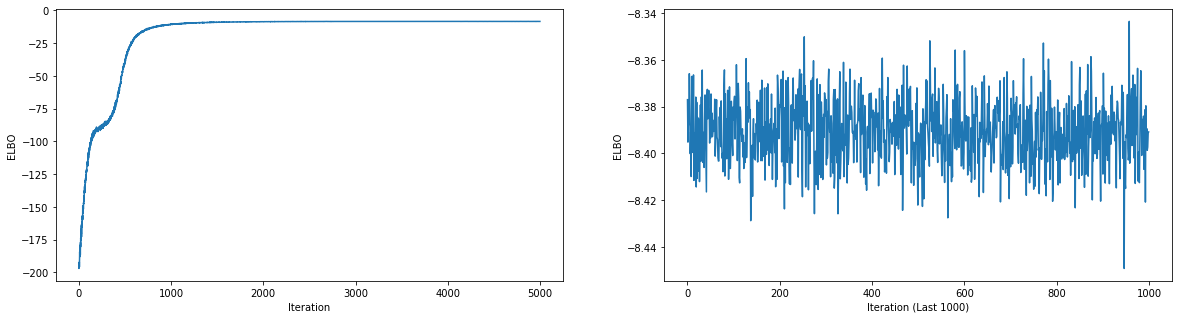

In [48]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(my_inference.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(my_inference.ELBO[-1000:])
ax[1].set_xlabel('Iteration (Last 1000)')
ax[1].set_ylabel('ELBO');

In [49]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

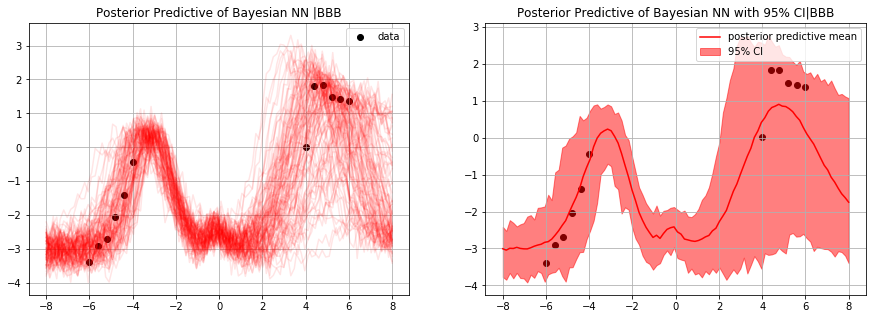

In [50]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

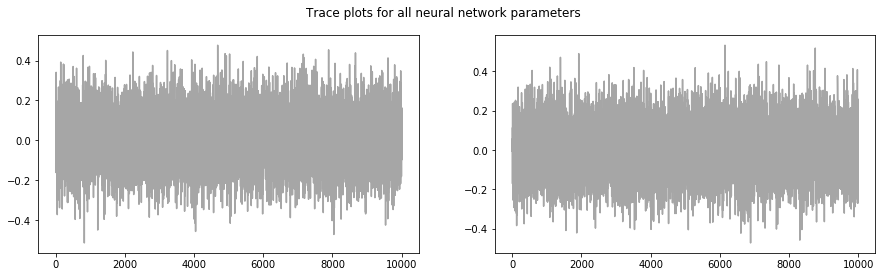

In [51]:
# check for convergence
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [52]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_random = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_random))

The Posterior Predictive Log likelihood of the observed data is -33.4643


/Users/susanaxu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: linewidths is ignored by contourf


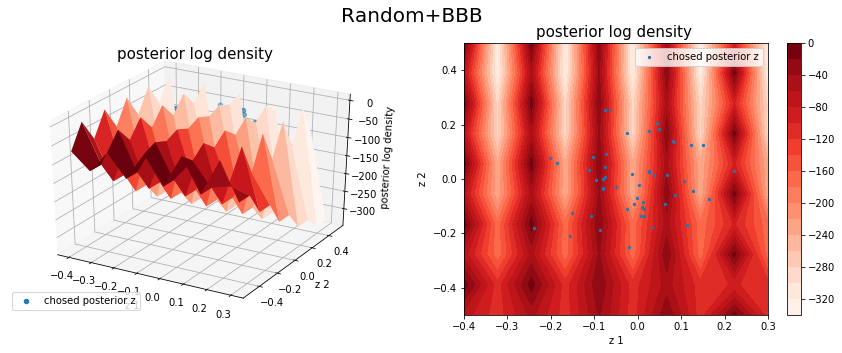

In [59]:
plot_posterior_likelihood(my_inference=my_inference, name='Random+BBB',zx_range=[-0.4,0.3], zy_range=[-0.5,0.5])

Notes: the blue points in BBB lies near the highest place, but not at the highest place.

**PCA Subspace.**

In [23]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [24]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [25]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=5)
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [26]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -15.281148235602133; gradient mag: 4.772889881790363
Iteration 200 lower bound -10.668284438554197; gradient mag: 3.8310108733805235
Iteration 400 lower bound -7.614380127248929; gradient mag: 2.9965357756826423
Iteration 600 lower bound -5.72497381187767; gradient mag: 2.321737930822825
Iteration 800 lower bound -4.402285744900138; gradient mag: 1.6895134158145582
Iteration 1000 lower bound -3.684586806107648; gradient mag: 1.1929098341183706
Iteration 1200 lower bound -3.282277819296061; gradient mag: 0.7912933654147407
Iteration 1400 lower bound -3.0987094372412636; gradient mag: 0.5652030991407123
Iteration 1600 lower bound -3.0156486866114705; gradient mag: 0.32457791801676616
Iteration 1800 lower bound -2.9625106146882394; gradient mag: 0.16017547052615386
Iteration 2000 lower bound -2.9720874231718986; gradient mag: 0.14857984409851285
Iteration 2200 lower bound -2.972496341439494; gradient mag: 0.04789098261750999
Iteration 2400 lower bound -2.9552383143

In [27]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 10.08 min


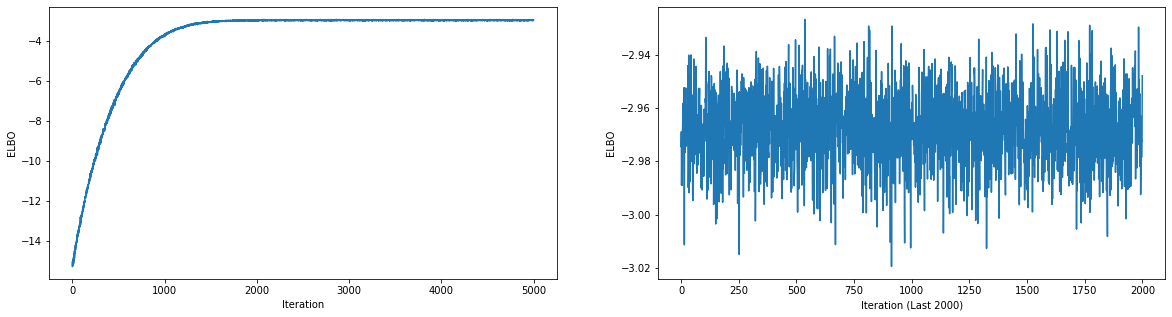

In [28]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(my_inference.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(my_inference.ELBO[-2000:])
ax[1].set_xlabel('Iteration (Last 2000)')
ax[1].set_ylabel('ELBO');

In [29]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

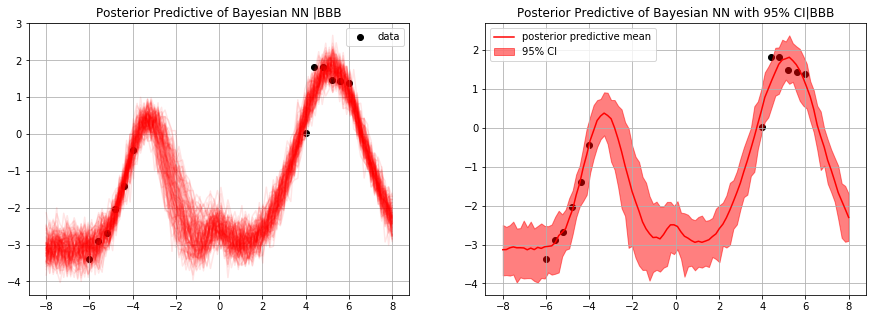

In [30]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

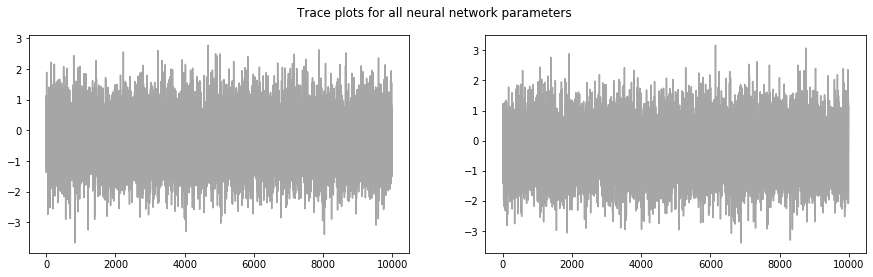

In [31]:
# check for convergence
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [32]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca))

The Posterior Predictive Log likelihood of the observed data is -2.7449


/Users/susanaxu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: linewidths is ignored by contourf


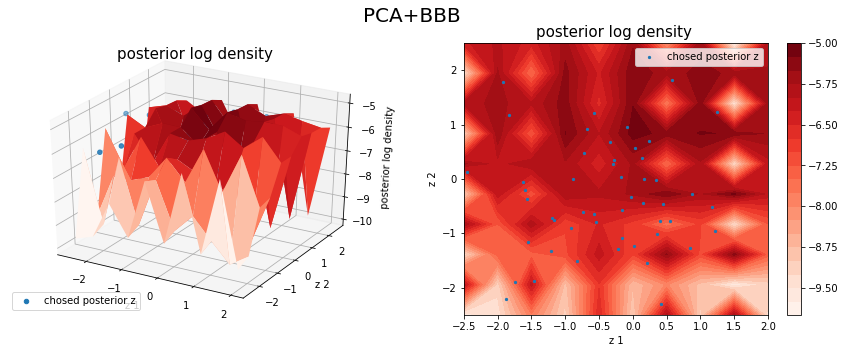

In [43]:
plot_posterior_likelihood(my_inference=my_inference, name='PCA+BBB',zx_range=[-2.5,2], zy_range=[-2.5,2.5])

**Curve Subspace.**

In [ ]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [ ]:
inference_bbb = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=inference_bbb.w_hat)

begin=time.time()
inference_bbb.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

In [26]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 28.98 min


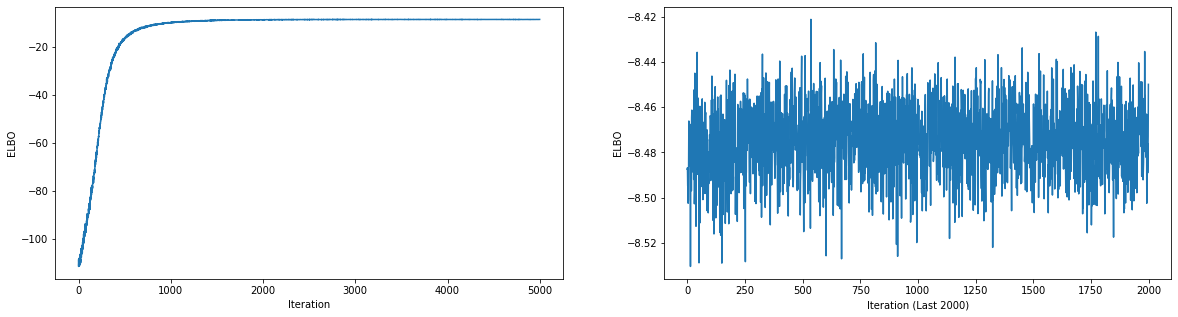

In [27]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(inference_bbb.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(inference_bbb.ELBO[-2000:])
ax[1].set_xlabel('Iteration (Last 2000)')
ax[1].set_ylabel('ELBO');

In [28]:
# get posterior z
n_sample = 100
post_sample = inference_bbb.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

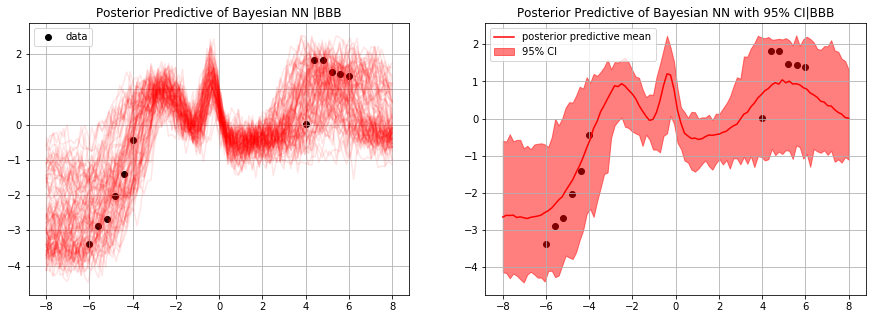

In [29]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

#### 4.2.3 Conclusion and Discussion

**A. Time Computation**

|Subspace Method|Inference Method|Subspace Construction (sec)|Subspace Inference (sec)|Total (sec)|
|---------------|----------------|---------------------|------------------|-----|
|Random  | HMC| 6.71|637.8|644.51|
|Random  | BBB| 6.71|559.2|565.91|
|PCA  | HMC| 7.13|535.2|542.33|
|PCA  | BBB| 7.13|604.8|611.93|
|Curve  | HMC| 122.12|384.9|507.02|
|Curve  | BBB| 122.12|1738.8|1860.92|

The table above summarizes both the subspace construction time and inference time for all methods. 
From the table we can see that, Curve Subspace requires the largest construction time, which is almost 20 times larger than that for PCA and Random Space. Speaking of the inference time, random and PCA subspaces requires around 500 sections, while curve subspace has diverged to a pretty small number (HMC) and large number (BBB).

To sum up, we can conclude that:
- Curve subspace needs a great more time in subspace construction compared with random and PCA subspace;
- Although PCA subpace needs slightly more time in subspace construction than random subspace, it usually requires less time in inference;
- The behavior of inference on curve subspace is unstable. More experiments might be needed to have a more complete picture of its behavior. We think a possible reason could be that the curve connecting the two endpoints is not well trained.

**B.Uncertainty Visualization**

![posterior visualization](https://i.ibb.co/NFM6vJy/posterior.png)


The plot above summarizes the posterior predictive of all subspace methods with both inference ways. From the plot we can see that:
- random and PCA subspace fit the data better than curve subspace.
- PCA provides more useful information about the uncertainty compared with random curve space. It has relatively thin intervals near the data points. They represent that the aleatoric uncertainty is small. It also has relatively fat uncertainty intervals where no data exists. They represent epistemic uncertainty which are good to have in this data set. Since we can reduce epistemic uncertainty by getting more data but can not easily tackle with aleatoric uncertainty, we prefer epistemic uncertainty than aleatoric uncertainty.

*For the two sections of comparison below, we will mainly focus on random subspace and PCA subspace*

**C. Computing the Fit**

|Subspace Method|Inference Method|Log-likelihood|
|--|--|--|
|Random |HMC|-3.7741|
|Random |BBB|-33.4643|
|PCA |HMC|-4.3521|
|PCA |BBB|-2.7449|



The table above summarizes posterior predictive log likelihood of the observed data. The larger the number is, the better the model fits the observed data. From the number above we can see that, PCA method is more stable than random subspace (which has a large variance in the log-likelihood performance due to the randomness by nature).

However, we should not over-emphasize the importance of this number when comparing the model as it only reveals how well the model fits the observed data but provides no information anywhere else.

**D.Posterior log-density Surface**

![log-density Surface](https://i.ibb.co/rwx8wyw/surface.png)

The plots above are the posterior log-density surfaces. The deeper the color is, the higher the log density is and the better the performance is. 

From the plots above we can generally say that PCA does a better job than random subspace. We see that the posterior $z$'s chosen in PCA are situated more in the darker areas, representing the local or even global maxima on the surface. There are also less $z$'s being placed near to the minima.

**Conclusion**

To sum up, we can say that PCA method performs the best due to its catching uncertainty ability and log likelihood. PCA subspace is quite stable across HMC and BBB methods, and it's both efficient in time consumption, insightful in uncertainty visualization, excellent in model fitness and the chosen $z$ is concentrated in the high log density area in subspace given sufficient variability. 

In the paper, however, it reports that the curve subspace has the best performance in NLL and accuracy. This difference could be caused by the fact that inference in our curve subspace has not been fully converged. It might also be due to the fact that we only have conducted limited experiments while curve subspace method is more complicated and might require more experiments. We argue that PCA subspace is still the best subspace to perform inference in, considering both of its time complexity and performance.


### 4.3. Extension

#### 4.3.1. Subspace VS Original Parameter Space
(To make the notebook as concise as possible, we only keep the relevant output in this section. To see the complete code of this extension, please visit: https://github.com/YimingXu1213/am207_Project/blob/master/src/originDimension.ipynb)

To fully test the improvement of subspace method regarding Bayesian deep neural network in terms of efficiency and uncertainty estimation, we compare their results with the one from converged HMC sampler on the original parameter space both in terms of uncertainty visualization and time consumption.

We trained the HMC sampler in the original parameter space as follows:

In [15]:
###Bayesian model parameterss
#covariance matrix of the Gaussian prior on weights
Sigma_W = 5**2 * np.eye(nn.D)
#Gaussian likelihood std
sigma_y = 0.5
#number of data points
N = 12
#precision matrix of the Gaussian prior on weights
Sigma_W_inv = np.linalg.inv(Sigma_W)
#determinant of the covaraince matrix of the Gaussian prior on weights
Sigma_W_det = np.linalg.det(Sigma_W)

###definition of the log prior
def log_prior(W):
    assert len(W.shape) == 2 and W.shape[1] == nn.D
    S = len(W)
    constant_W = -0.5 * (nn.D * np.log(2 * np.pi) + np.log(Sigma_W_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
    assert exponential_W.shape == (S, )
    log_p_W = constant_W + exponential_W
    return log_p_W

###definition of the log likelihood
def log_lklhd(W):
    assert len(W.shape) == 2 and W.shape[1] == nn.D
    S = W.shape[0]
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
    exponential = -0.5 * sigma_y**-2 * np.sum((y.reshape(1, -1).reshape((1, 1, N)) - nn.forward(W, x.reshape(1, -1)))**2, axis=2).flatten()
    assert exponential.shape == (S, )
    return constant + exponential

def joint_log_nn(W):
    return log_prior(W) + log_lklhd(W)

In [23]:
params_nn_converge = {'step_size':0.01, 
          'leapfrog_steps':10, 
          'total_samples':500000, 
          'burn_in':.1, 
          'thinning_factor':2,
          'position_init': nn.weights.reshape((1, nn.D))}

U_function_nn = lambda W: -joint_log_nn(W)

In [24]:
def get_HMC(U_function, params):
    """
    Input
    ----------    
    U_function : func
    params: a dictionary, containing key-value pairs as follows:
        step_size: float
        leapfrog_steps: int
        total_samples: int
        burn_in: float
        thinning_factor: int
        position_init: np.array, with shape (D, )


    Output
    -------
    np.array, with shape (n_samples_clean, D)
    """
    # read parameters
    step_size = params['step_size']
    leapfrog_steps = params['leapfrog_steps']
    total_samples = params['total_samples']
    burn_in = params['burn_in']
    thinning_factor = params['thinning_factor']
    position_init = params['position_init']

    dUdq = grad(U_function) # define dUdq   
    
    samples = list([position_init]) 
    size = (total_samples, ) + (position_init.shape[-1], ) # define the size of output
    
    momentum = st.norm(0, 1)
    alpha_list = []
    for p0 in momentum.rvs(size = size): # directly generate moments for shape (n_samples, n_params)
        # Leap-Frog Integration
        q_new, p_new = leap_frog(samples[-1], p0, dUdq, leapfrog_steps, step_size)

        # correction for simulation error
        cur_total = U_function(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_total = U_function(q_new) - np.sum(momentum.logpdf(p_new))
        
        alpha = min(1, np.exp(cur_total - new_total))
        u = np.random.uniform(0,1)
        
        # constantly adjust the step_size according to acceptance rate
        if alpha < 0.5:
            step_size -= (0.5 - float(alpha)) * 0.005
        elif alpha > 0.7:
            step_size += (float(alpha) - 0.7) * 0.005
        alpha_list.append(alpha)
        
        if u <= alpha:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))
        if (len(samples) - 1) % 100 == 0:
            print('{0} Samples. Acceptance Rate: {1:6.2f} % step_size : {2:6.4f}'.format(len(samples)-1, float(np.mean(alpha_list[len(samples)-101:len(samples)-1]) * 100), step_size))
    
    output_samples = np.array(samples[1:]).reshape(total_samples, position_init.shape[-1]) 
    
    return output_samples[int(burn_in * total_samples)::thinning_factor]

In [25]:
begin=time.time()
np.random.seed(2019)
samples_nn_HMC_converge = get_HMC(U_function_nn, params_nn_converge)
end=time.time()

100 Samples. Acceptance Rate:  62.50 % step_size : 0.0125
200 Samples. Acceptance Rate:  62.16 % step_size : 0.0158
300 Samples. Acceptance Rate:  63.55 % step_size : 0.0252
400 Samples. Acceptance Rate:  61.86 % step_size : 0.0238
500 Samples. Acceptance Rate:  60.43 % step_size : 0.0190
600 Samples. Acceptance Rate:  62.87 % step_size : 0.0211
700 Samples. Acceptance Rate:  62.13 % step_size : 0.0225
800 Samples. Acceptance Rate:  62.78 % step_size : 0.0295
900 Samples. Acceptance Rate:  61.22 % step_size : 0.0282
1000 Samples. Acceptance Rate:  60.05 % step_size : 0.0225
1100 Samples. Acceptance Rate:  60.95 % step_size : 0.0208
1200 Samples. Acceptance Rate:  63.55 % step_size : 0.0258
1300 Samples. Acceptance Rate:  62.44 % step_size : 0.0298
1400 Samples. Acceptance Rate:  61.70 % step_size : 0.0264
1500 Samples. Acceptance Rate:  61.30 % step_size : 0.0240
1600 Samples. Acceptance Rate:  60.17 % step_size : 0.0172
1700 Samples. Acceptance Rate:  64.04 % step_size : 0.0254
1800 S

14000 Samples. Acceptance Rate:  60.71 % step_size : 0.0101
14100 Samples. Acceptance Rate:  62.08 % step_size : 0.0085
14200 Samples. Acceptance Rate:  63.05 % step_size : 0.0108
14300 Samples. Acceptance Rate:  62.06 % step_size : 0.0099
14400 Samples. Acceptance Rate:  62.56 % step_size : 0.0131
14500 Samples. Acceptance Rate:  61.48 % step_size : 0.0100
14600 Samples. Acceptance Rate:  62.50 % step_size : 0.0101
14700 Samples. Acceptance Rate:  62.70 % step_size : 0.0105
14800 Samples. Acceptance Rate:  63.17 % step_size : 0.0158
14900 Samples. Acceptance Rate:  63.98 % step_size : 0.0243
15000 Samples. Acceptance Rate:  62.42 % step_size : 0.0264
15100 Samples. Acceptance Rate:  62.06 % step_size : 0.0261
15200 Samples. Acceptance Rate:  60.82 % step_size : 0.0214
15300 Samples. Acceptance Rate:  62.89 % step_size : 0.0207
15400 Samples. Acceptance Rate:  64.47 % step_size : 0.0268
15500 Samples. Acceptance Rate:  60.69 % step_size : 0.0211
15600 Samples. Acceptance Rate:  61.95 %

27700 Samples. Acceptance Rate:  61.26 % step_size : 0.0184
27800 Samples. Acceptance Rate:  62.96 % step_size : 0.0225
27900 Samples. Acceptance Rate:  60.89 % step_size : 0.0170
28000 Samples. Acceptance Rate:  61.83 % step_size : 0.0143
28100 Samples. Acceptance Rate:  61.79 % step_size : 0.0146
28200 Samples. Acceptance Rate:  60.37 % step_size : 0.0104
28300 Samples. Acceptance Rate:  63.62 % step_size : 0.0178
28400 Samples. Acceptance Rate:  62.75 % step_size : 0.0226
28500 Samples. Acceptance Rate:  62.24 % step_size : 0.0227
28600 Samples. Acceptance Rate:  62.59 % step_size : 0.0242
28700 Samples. Acceptance Rate:  61.77 % step_size : 0.0222
28800 Samples. Acceptance Rate:  60.80 % step_size : 0.0204
28900 Samples. Acceptance Rate:  61.80 % step_size : 0.0192
29000 Samples. Acceptance Rate:  63.37 % step_size : 0.0235
29100 Samples. Acceptance Rate:  60.55 % step_size : 0.0189
29200 Samples. Acceptance Rate:  63.43 % step_size : 0.0239
29300 Samples. Acceptance Rate:  65.05 %

41400 Samples. Acceptance Rate:  63.21 % step_size : 0.0233
41500 Samples. Acceptance Rate:  61.68 % step_size : 0.0232
41600 Samples. Acceptance Rate:  62.61 % step_size : 0.0246
41700 Samples. Acceptance Rate:  62.11 % step_size : 0.0249
41800 Samples. Acceptance Rate:  61.78 % step_size : 0.0228
41900 Samples. Acceptance Rate:  62.18 % step_size : 0.0213
42000 Samples. Acceptance Rate:  62.77 % step_size : 0.0257
42100 Samples. Acceptance Rate:  61.97 % step_size : 0.0242
42200 Samples. Acceptance Rate:  63.08 % step_size : 0.0296
42300 Samples. Acceptance Rate:  60.71 % step_size : 0.0234
42400 Samples. Acceptance Rate:  61.97 % step_size : 0.0207
42500 Samples. Acceptance Rate:  60.92 % step_size : 0.0172
42600 Samples. Acceptance Rate:  61.13 % step_size : 0.0146
42700 Samples. Acceptance Rate:  61.62 % step_size : 0.0121
42800 Samples. Acceptance Rate:  63.50 % step_size : 0.0212
42900 Samples. Acceptance Rate:  63.99 % step_size : 0.0276
43000 Samples. Acceptance Rate:  59.75 %

55100 Samples. Acceptance Rate:  62.29 % step_size : 0.0260
55200 Samples. Acceptance Rate:  57.67 % step_size : 0.0116
55300 Samples. Acceptance Rate:  62.12 % step_size : 0.0128
55400 Samples. Acceptance Rate:  63.64 % step_size : 0.0197
55500 Samples. Acceptance Rate:  61.60 % step_size : 0.0190
55600 Samples. Acceptance Rate:  62.07 % step_size : 0.0225
55700 Samples. Acceptance Rate:  61.42 % step_size : 0.0209
55800 Samples. Acceptance Rate:  61.54 % step_size : 0.0226
55900 Samples. Acceptance Rate:  62.29 % step_size : 0.0234
56000 Samples. Acceptance Rate:  62.93 % step_size : 0.0283
56100 Samples. Acceptance Rate:  61.10 % step_size : 0.0229
56200 Samples. Acceptance Rate:  61.34 % step_size : 0.0210
56300 Samples. Acceptance Rate:  63.88 % step_size : 0.0281
56400 Samples. Acceptance Rate:  62.67 % step_size : 0.0339
56500 Samples. Acceptance Rate:  59.44 % step_size : 0.0234
56600 Samples. Acceptance Rate:  59.54 % step_size : 0.0144
56700 Samples. Acceptance Rate:  65.10 %

68800 Samples. Acceptance Rate:  59.63 % step_size : 0.0195
68900 Samples. Acceptance Rate:  63.83 % step_size : 0.0256
69000 Samples. Acceptance Rate:  63.18 % step_size : 0.0283
69100 Samples. Acceptance Rate:  60.33 % step_size : 0.0215
69200 Samples. Acceptance Rate:  61.32 % step_size : 0.0208
69300 Samples. Acceptance Rate:  61.60 % step_size : 0.0179
69400 Samples. Acceptance Rate:  62.33 % step_size : 0.0180
69500 Samples. Acceptance Rate:  60.35 % step_size : 0.0119
69600 Samples. Acceptance Rate:  63.78 % step_size : 0.0206
69700 Samples. Acceptance Rate:  62.00 % step_size : 0.0208
69800 Samples. Acceptance Rate:  63.06 % step_size : 0.0234
69900 Samples. Acceptance Rate:  60.93 % step_size : 0.0173
70000 Samples. Acceptance Rate:  64.55 % step_size : 0.0268
70100 Samples. Acceptance Rate:  61.30 % step_size : 0.0241
70200 Samples. Acceptance Rate:  62.12 % step_size : 0.0228
70300 Samples. Acceptance Rate:  62.81 % step_size : 0.0258
70400 Samples. Acceptance Rate:  60.78 %

82500 Samples. Acceptance Rate:  64.13 % step_size : 0.0246
82600 Samples. Acceptance Rate:  61.92 % step_size : 0.0247
82700 Samples. Acceptance Rate:  62.29 % step_size : 0.0257
82800 Samples. Acceptance Rate:  61.95 % step_size : 0.0250
82900 Samples. Acceptance Rate:  63.00 % step_size : 0.0267
83000 Samples. Acceptance Rate:  59.17 % step_size : 0.0184
83100 Samples. Acceptance Rate:  63.20 % step_size : 0.0218
83200 Samples. Acceptance Rate:  61.75 % step_size : 0.0200
83300 Samples. Acceptance Rate:  62.43 % step_size : 0.0235
83400 Samples. Acceptance Rate:  61.22 % step_size : 0.0205
83500 Samples. Acceptance Rate:  64.98 % step_size : 0.0359
83600 Samples. Acceptance Rate:  60.60 % step_size : 0.0282
83700 Samples. Acceptance Rate:  62.69 % step_size : 0.0290
83800 Samples. Acceptance Rate:  63.85 % step_size : 0.0352
83900 Samples. Acceptance Rate:  60.49 % step_size : 0.0325
84000 Samples. Acceptance Rate:  59.32 % step_size : 0.0234
84100 Samples. Acceptance Rate:  65.05 %

96200 Samples. Acceptance Rate:  62.72 % step_size : 0.0305
96300 Samples. Acceptance Rate:  60.28 % step_size : 0.0220
96400 Samples. Acceptance Rate:  62.85 % step_size : 0.0240
96500 Samples. Acceptance Rate:  60.53 % step_size : 0.0170
96600 Samples. Acceptance Rate:  62.60 % step_size : 0.0197
96700 Samples. Acceptance Rate:  63.31 % step_size : 0.0233
96800 Samples. Acceptance Rate:  58.91 % step_size : 0.0111
96900 Samples. Acceptance Rate:  62.88 % step_size : 0.0142
97000 Samples. Acceptance Rate:  64.50 % step_size : 0.0256
97100 Samples. Acceptance Rate:  61.07 % step_size : 0.0195
97200 Samples. Acceptance Rate:  60.02 % step_size : 0.0118
97300 Samples. Acceptance Rate:  64.76 % step_size : 0.0255
97400 Samples. Acceptance Rate:  60.33 % step_size : 0.0189
97500 Samples. Acceptance Rate:  61.90 % step_size : 0.0195
97600 Samples. Acceptance Rate:  64.10 % step_size : 0.0254
97700 Samples. Acceptance Rate:  60.20 % step_size : 0.0177
97800 Samples. Acceptance Rate:  62.29 %

109700 Samples. Acceptance Rate:  62.61 % step_size : 0.0177
109800 Samples. Acceptance Rate:  62.31 % step_size : 0.0191
109900 Samples. Acceptance Rate:  63.33 % step_size : 0.0238
110000 Samples. Acceptance Rate:  59.46 % step_size : 0.0157
110100 Samples. Acceptance Rate:  63.75 % step_size : 0.0221
110200 Samples. Acceptance Rate:  61.90 % step_size : 0.0216
110300 Samples. Acceptance Rate:  62.12 % step_size : 0.0226
110400 Samples. Acceptance Rate:  62.01 % step_size : 0.0229
110500 Samples. Acceptance Rate:  61.59 % step_size : 0.0223
110600 Samples. Acceptance Rate:  60.74 % step_size : 0.0185
110700 Samples. Acceptance Rate:  63.37 % step_size : 0.0255
110800 Samples. Acceptance Rate:  62.83 % step_size : 0.0258
110900 Samples. Acceptance Rate:  60.35 % step_size : 0.0187
111000 Samples. Acceptance Rate:  61.95 % step_size : 0.0209
111100 Samples. Acceptance Rate:  62.15 % step_size : 0.0198
111200 Samples. Acceptance Rate:  60.12 % step_size : 0.0125
111300 Samples. Acceptan

123200 Samples. Acceptance Rate:  62.83 % step_size : 0.0268
123300 Samples. Acceptance Rate:  61.94 % step_size : 0.0250
123400 Samples. Acceptance Rate:  62.05 % step_size : 0.0228
123500 Samples. Acceptance Rate:  62.34 % step_size : 0.0230
123600 Samples. Acceptance Rate:  62.84 % step_size : 0.0255
123700 Samples. Acceptance Rate:  60.26 % step_size : 0.0191
123800 Samples. Acceptance Rate:  61.26 % step_size : 0.0172
123900 Samples. Acceptance Rate:  62.18 % step_size : 0.0173
124000 Samples. Acceptance Rate:  62.28 % step_size : 0.0200
124100 Samples. Acceptance Rate:  62.06 % step_size : 0.0190
124200 Samples. Acceptance Rate:  64.83 % step_size : 0.0275
124300 Samples. Acceptance Rate:  62.16 % step_size : 0.0268
124400 Samples. Acceptance Rate:  62.33 % step_size : 0.0263
124500 Samples. Acceptance Rate:  61.07 % step_size : 0.0227
124600 Samples. Acceptance Rate:  62.97 % step_size : 0.0279
124700 Samples. Acceptance Rate:  61.49 % step_size : 0.0249
124800 Samples. Acceptan

136700 Samples. Acceptance Rate:  62.12 % step_size : 0.0232
136800 Samples. Acceptance Rate:  61.66 % step_size : 0.0217
136900 Samples. Acceptance Rate:  62.09 % step_size : 0.0235
137000 Samples. Acceptance Rate:  61.71 % step_size : 0.0208
137100 Samples. Acceptance Rate:  63.17 % step_size : 0.0255
137200 Samples. Acceptance Rate:  59.16 % step_size : 0.0157
137300 Samples. Acceptance Rate:  64.76 % step_size : 0.0257
137400 Samples. Acceptance Rate:  62.44 % step_size : 0.0248
137500 Samples. Acceptance Rate:  62.50 % step_size : 0.0253
137600 Samples. Acceptance Rate:  60.53 % step_size : 0.0171
137700 Samples. Acceptance Rate:  62.46 % step_size : 0.0174
137800 Samples. Acceptance Rate:  63.80 % step_size : 0.0232
137900 Samples. Acceptance Rate:  62.37 % step_size : 0.0241
138000 Samples. Acceptance Rate:  60.54 % step_size : 0.0182
138100 Samples. Acceptance Rate:  61.67 % step_size : 0.0159
138200 Samples. Acceptance Rate:  64.07 % step_size : 0.0238
138300 Samples. Acceptan

150200 Samples. Acceptance Rate:  62.50 % step_size : 0.0073
150300 Samples. Acceptance Rate:  63.12 % step_size : 0.0089
150400 Samples. Acceptance Rate:  62.05 % step_size : 0.0082
150500 Samples. Acceptance Rate:  61.73 % step_size : 0.0091
150600 Samples. Acceptance Rate:  62.03 % step_size : 0.0104
150700 Samples. Acceptance Rate:  61.20 % step_size : 0.0082
150800 Samples. Acceptance Rate:  62.20 % step_size : 0.0096
150900 Samples. Acceptance Rate:  62.42 % step_size : 0.0112
151000 Samples. Acceptance Rate:  60.69 % step_size : 0.0073
151100 Samples. Acceptance Rate:  62.64 % step_size : 0.0095
151200 Samples. Acceptance Rate:  60.88 % step_size : 0.0072
151300 Samples. Acceptance Rate:  62.67 % step_size : 0.0100
151400 Samples. Acceptance Rate:  61.85 % step_size : 0.0090
151500 Samples. Acceptance Rate:  62.08 % step_size : 0.0103
151600 Samples. Acceptance Rate:  62.85 % step_size : 0.0107
151700 Samples. Acceptance Rate:  62.86 % step_size : 0.0128
151800 Samples. Acceptan

163700 Samples. Acceptance Rate:  62.60 % step_size : 0.0208
163800 Samples. Acceptance Rate:  61.86 % step_size : 0.0219
163900 Samples. Acceptance Rate:  62.59 % step_size : 0.0250
164000 Samples. Acceptance Rate:  61.35 % step_size : 0.0260
164100 Samples. Acceptance Rate:  61.93 % step_size : 0.0249
164200 Samples. Acceptance Rate:  63.58 % step_size : 0.0282
164300 Samples. Acceptance Rate:  59.47 % step_size : 0.0183
164400 Samples. Acceptance Rate:  64.45 % step_size : 0.0285
164500 Samples. Acceptance Rate:  60.26 % step_size : 0.0215
164600 Samples. Acceptance Rate:  59.53 % step_size : 0.0130
164700 Samples. Acceptance Rate:  64.02 % step_size : 0.0245
164800 Samples. Acceptance Rate:  59.82 % step_size : 0.0168
164900 Samples. Acceptance Rate:  64.12 % step_size : 0.0258
165000 Samples. Acceptance Rate:  63.66 % step_size : 0.0322
165100 Samples. Acceptance Rate:  60.86 % step_size : 0.0247
165200 Samples. Acceptance Rate:  63.86 % step_size : 0.0323
165300 Samples. Acceptan

177200 Samples. Acceptance Rate:  62.98 % step_size : 0.0257
177300 Samples. Acceptance Rate:  61.37 % step_size : 0.0243
177400 Samples. Acceptance Rate:  59.20 % step_size : 0.0139
177500 Samples. Acceptance Rate:  63.63 % step_size : 0.0207
177600 Samples. Acceptance Rate:  63.75 % step_size : 0.0278
177700 Samples. Acceptance Rate:  61.69 % step_size : 0.0247
177800 Samples. Acceptance Rate:  62.75 % step_size : 0.0315
177900 Samples. Acceptance Rate:  61.33 % step_size : 0.0291
178000 Samples. Acceptance Rate:  63.42 % step_size : 0.0376
178100 Samples. Acceptance Rate:  60.55 % step_size : 0.0315
178200 Samples. Acceptance Rate:  60.29 % step_size : 0.0215
178300 Samples. Acceptance Rate:  62.16 % step_size : 0.0212
178400 Samples. Acceptance Rate:  59.17 % step_size : 0.0100
178500 Samples. Acceptance Rate:  63.42 % step_size : 0.0160
178600 Samples. Acceptance Rate:  60.98 % step_size : 0.0140
178700 Samples. Acceptance Rate:  60.97 % step_size : 0.0085
178800 Samples. Acceptan

190700 Samples. Acceptance Rate:  61.77 % step_size : 0.0264
190800 Samples. Acceptance Rate:  61.46 % step_size : 0.0233
190900 Samples. Acceptance Rate:  61.24 % step_size : 0.0202
191000 Samples. Acceptance Rate:  61.47 % step_size : 0.0197
191100 Samples. Acceptance Rate:  63.12 % step_size : 0.0259
191200 Samples. Acceptance Rate:  60.16 % step_size : 0.0205
191300 Samples. Acceptance Rate:  65.04 % step_size : 0.0300
191400 Samples. Acceptance Rate:  60.01 % step_size : 0.0211
191500 Samples. Acceptance Rate:  61.54 % step_size : 0.0187
191600 Samples. Acceptance Rate:  61.88 % step_size : 0.0205
191700 Samples. Acceptance Rate:  61.24 % step_size : 0.0195
191800 Samples. Acceptance Rate:  60.46 % step_size : 0.0155
191900 Samples. Acceptance Rate:  65.44 % step_size : 0.0261
192000 Samples. Acceptance Rate:  61.46 % step_size : 0.0222
192100 Samples. Acceptance Rate:  61.60 % step_size : 0.0217
192200 Samples. Acceptance Rate:  60.53 % step_size : 0.0182
192300 Samples. Acceptan

204200 Samples. Acceptance Rate:  61.40 % step_size : 0.0181
204300 Samples. Acceptance Rate:  63.29 % step_size : 0.0230
204400 Samples. Acceptance Rate:  60.41 % step_size : 0.0155
204500 Samples. Acceptance Rate:  64.31 % step_size : 0.0231
204600 Samples. Acceptance Rate:  62.96 % step_size : 0.0301
204700 Samples. Acceptance Rate:  61.47 % step_size : 0.0256
204800 Samples. Acceptance Rate:  62.36 % step_size : 0.0256
204900 Samples. Acceptance Rate:  61.24 % step_size : 0.0225
205000 Samples. Acceptance Rate:  62.71 % step_size : 0.0222
205100 Samples. Acceptance Rate:  62.20 % step_size : 0.0217
205200 Samples. Acceptance Rate:  63.71 % step_size : 0.0269
205300 Samples. Acceptance Rate:  61.37 % step_size : 0.0248
205400 Samples. Acceptance Rate:  61.94 % step_size : 0.0204
205500 Samples. Acceptance Rate:  61.17 % step_size : 0.0173
205600 Samples. Acceptance Rate:  62.93 % step_size : 0.0206
205700 Samples. Acceptance Rate:  62.75 % step_size : 0.0234
205800 Samples. Acceptan

217700 Samples. Acceptance Rate:  63.63 % step_size : 0.0252
217800 Samples. Acceptance Rate:  60.68 % step_size : 0.0186
217900 Samples. Acceptance Rate:  64.36 % step_size : 0.0253
218000 Samples. Acceptance Rate:  62.71 % step_size : 0.0276
218100 Samples. Acceptance Rate:  59.78 % step_size : 0.0184
218200 Samples. Acceptance Rate:  62.97 % step_size : 0.0205
218300 Samples. Acceptance Rate:  59.03 % step_size : 0.0089
218400 Samples. Acceptance Rate:  61.81 % step_size : 0.0090
218500 Samples. Acceptance Rate:  62.06 % step_size : 0.0103
218600 Samples. Acceptance Rate:  62.99 % step_size : 0.0152
218700 Samples. Acceptance Rate:  63.84 % step_size : 0.0225
218800 Samples. Acceptance Rate:  61.44 % step_size : 0.0198
218900 Samples. Acceptance Rate:  61.33 % step_size : 0.0183
219000 Samples. Acceptance Rate:  60.93 % step_size : 0.0156
219100 Samples. Acceptance Rate:  64.63 % step_size : 0.0247
219200 Samples. Acceptance Rate:  60.17 % step_size : 0.0177
219300 Samples. Acceptan

231200 Samples. Acceptance Rate:  63.94 % step_size : 0.0251
231300 Samples. Acceptance Rate:  61.21 % step_size : 0.0245
231400 Samples. Acceptance Rate:  62.73 % step_size : 0.0274
231500 Samples. Acceptance Rate:  61.46 % step_size : 0.0250
231600 Samples. Acceptance Rate:  61.75 % step_size : 0.0255
231700 Samples. Acceptance Rate:  62.55 % step_size : 0.0269
231800 Samples. Acceptance Rate:  61.99 % step_size : 0.0266
231900 Samples. Acceptance Rate:  60.92 % step_size : 0.0217
232000 Samples. Acceptance Rate:  62.53 % step_size : 0.0229
232100 Samples. Acceptance Rate:  63.45 % step_size : 0.0267
232200 Samples. Acceptance Rate:  60.33 % step_size : 0.0193
232300 Samples. Acceptance Rate:  61.33 % step_size : 0.0160
232400 Samples. Acceptance Rate:  63.34 % step_size : 0.0246
232500 Samples. Acceptance Rate:  61.80 % step_size : 0.0261
232600 Samples. Acceptance Rate:  60.05 % step_size : 0.0205
232700 Samples. Acceptance Rate:  64.28 % step_size : 0.0307
232800 Samples. Acceptan

244700 Samples. Acceptance Rate:  64.25 % step_size : 0.0225
244800 Samples. Acceptance Rate:  63.22 % step_size : 0.0253
244900 Samples. Acceptance Rate:  62.58 % step_size : 0.0232
245000 Samples. Acceptance Rate:  61.94 % step_size : 0.0240
245100 Samples. Acceptance Rate:  62.12 % step_size : 0.0218
245200 Samples. Acceptance Rate:  60.48 % step_size : 0.0143
245300 Samples. Acceptance Rate:  63.92 % step_size : 0.0221
245400 Samples. Acceptance Rate:  61.23 % step_size : 0.0224
245500 Samples. Acceptance Rate:  61.65 % step_size : 0.0205
245600 Samples. Acceptance Rate:  63.70 % step_size : 0.0268
245700 Samples. Acceptance Rate:  60.95 % step_size : 0.0207
245800 Samples. Acceptance Rate:  61.15 % step_size : 0.0186
245900 Samples. Acceptance Rate:  62.78 % step_size : 0.0217
246000 Samples. Acceptance Rate:  62.92 % step_size : 0.0246
246100 Samples. Acceptance Rate:  59.74 % step_size : 0.0152
246200 Samples. Acceptance Rate:  62.68 % step_size : 0.0172
246300 Samples. Acceptan

258200 Samples. Acceptance Rate:  61.83 % step_size : 0.0230
258300 Samples. Acceptance Rate:  62.67 % step_size : 0.0255
258400 Samples. Acceptance Rate:  60.39 % step_size : 0.0187
258500 Samples. Acceptance Rate:  61.30 % step_size : 0.0152
258600 Samples. Acceptance Rate:  64.90 % step_size : 0.0256
258700 Samples. Acceptance Rate:  59.49 % step_size : 0.0147
258800 Samples. Acceptance Rate:  61.74 % step_size : 0.0152
258900 Samples. Acceptance Rate:  64.33 % step_size : 0.0207
259000 Samples. Acceptance Rate:  61.54 % step_size : 0.0192
259100 Samples. Acceptance Rate:  61.34 % step_size : 0.0160
259200 Samples. Acceptance Rate:  63.90 % step_size : 0.0229
259300 Samples. Acceptance Rate:  59.94 % step_size : 0.0157
259400 Samples. Acceptance Rate:  62.76 % step_size : 0.0181
259500 Samples. Acceptance Rate:  62.37 % step_size : 0.0178
259600 Samples. Acceptance Rate:  60.50 % step_size : 0.0119
259700 Samples. Acceptance Rate:  61.57 % step_size : 0.0117
259800 Samples. Acceptan

271700 Samples. Acceptance Rate:  59.28 % step_size : 0.0193
271800 Samples. Acceptance Rate:  63.13 % step_size : 0.0236
271900 Samples. Acceptance Rate:  60.30 % step_size : 0.0176
272000 Samples. Acceptance Rate:  65.46 % step_size : 0.0300
272100 Samples. Acceptance Rate:  61.67 % step_size : 0.0283
272200 Samples. Acceptance Rate:  60.79 % step_size : 0.0214
272300 Samples. Acceptance Rate:  61.63 % step_size : 0.0195
272400 Samples. Acceptance Rate:  61.41 % step_size : 0.0177
272500 Samples. Acceptance Rate:  60.67 % step_size : 0.0125
272600 Samples. Acceptance Rate:  62.48 % step_size : 0.0141
272700 Samples. Acceptance Rate:  62.56 % step_size : 0.0168
272800 Samples. Acceptance Rate:  63.97 % step_size : 0.0257
272900 Samples. Acceptance Rate:  61.22 % step_size : 0.0225
273000 Samples. Acceptance Rate:  60.49 % step_size : 0.0173
273100 Samples. Acceptance Rate:  63.28 % step_size : 0.0218
273200 Samples. Acceptance Rate:  63.23 % step_size : 0.0287
273300 Samples. Acceptan

285200 Samples. Acceptance Rate:  63.80 % step_size : 0.0216
285300 Samples. Acceptance Rate:  63.05 % step_size : 0.0253
285400 Samples. Acceptance Rate:  60.83 % step_size : 0.0214
285500 Samples. Acceptance Rate:  62.16 % step_size : 0.0222
285600 Samples. Acceptance Rate:  60.78 % step_size : 0.0200
285700 Samples. Acceptance Rate:  61.38 % step_size : 0.0204
285800 Samples. Acceptance Rate:  62.72 % step_size : 0.0215
285900 Samples. Acceptance Rate:  60.88 % step_size : 0.0175
286000 Samples. Acceptance Rate:  64.07 % step_size : 0.0235
286100 Samples. Acceptance Rate:  62.29 % step_size : 0.0209
286200 Samples. Acceptance Rate:  60.47 % step_size : 0.0143
286300 Samples. Acceptance Rate:  61.51 % step_size : 0.0122
286400 Samples. Acceptance Rate:  60.74 % step_size : 0.0097
286500 Samples. Acceptance Rate:  61.66 % step_size : 0.0094
286600 Samples. Acceptance Rate:  61.73 % step_size : 0.0085
286700 Samples. Acceptance Rate:  62.74 % step_size : 0.0106
286800 Samples. Acceptan

298700 Samples. Acceptance Rate:  58.71 % step_size : 0.0140
298800 Samples. Acceptance Rate:  62.10 % step_size : 0.0142
298900 Samples. Acceptance Rate:  63.07 % step_size : 0.0161
299000 Samples. Acceptance Rate:  65.37 % step_size : 0.0268
299100 Samples. Acceptance Rate:  61.25 % step_size : 0.0235
299200 Samples. Acceptance Rate:  62.41 % step_size : 0.0265
299300 Samples. Acceptance Rate:  58.71 % step_size : 0.0166
299400 Samples. Acceptance Rate:  63.05 % step_size : 0.0201
299500 Samples. Acceptance Rate:  61.12 % step_size : 0.0181
299600 Samples. Acceptance Rate:  62.28 % step_size : 0.0182
299700 Samples. Acceptance Rate:  62.66 % step_size : 0.0200
299800 Samples. Acceptance Rate:  61.49 % step_size : 0.0179
299900 Samples. Acceptance Rate:  62.58 % step_size : 0.0198
300000 Samples. Acceptance Rate:  62.81 % step_size : 0.0216
300100 Samples. Acceptance Rate:  62.00 % step_size : 0.0205
300200 Samples. Acceptance Rate:  59.48 % step_size : 0.0122
300300 Samples. Acceptan

312200 Samples. Acceptance Rate:  63.47 % step_size : 0.0226
312300 Samples. Acceptance Rate:  61.48 % step_size : 0.0207
312400 Samples. Acceptance Rate:  62.45 % step_size : 0.0225
312500 Samples. Acceptance Rate:  62.84 % step_size : 0.0244
312600 Samples. Acceptance Rate:  61.15 % step_size : 0.0198
312700 Samples. Acceptance Rate:  62.30 % step_size : 0.0201
312800 Samples. Acceptance Rate:  61.37 % step_size : 0.0157
312900 Samples. Acceptance Rate:  60.89 % step_size : 0.0127
313000 Samples. Acceptance Rate:  62.11 % step_size : 0.0135
313100 Samples. Acceptance Rate:  61.70 % step_size : 0.0133
313200 Samples. Acceptance Rate:  65.92 % step_size : 0.0267
313300 Samples. Acceptance Rate:  60.97 % step_size : 0.0237
313400 Samples. Acceptance Rate:  61.07 % step_size : 0.0197
313500 Samples. Acceptance Rate:  63.22 % step_size : 0.0240
313600 Samples. Acceptance Rate:  63.33 % step_size : 0.0271
313700 Samples. Acceptance Rate:  60.44 % step_size : 0.0220
313800 Samples. Acceptan

325700 Samples. Acceptance Rate:  63.12 % step_size : 0.0285
325800 Samples. Acceptance Rate:  59.82 % step_size : 0.0218
325900 Samples. Acceptance Rate:  62.26 % step_size : 0.0201
326000 Samples. Acceptance Rate:  62.84 % step_size : 0.0230
326100 Samples. Acceptance Rate:  62.75 % step_size : 0.0255
326200 Samples. Acceptance Rate:  61.56 % step_size : 0.0230
326300 Samples. Acceptance Rate:  61.87 % step_size : 0.0223
326400 Samples. Acceptance Rate:  62.23 % step_size : 0.0242
326500 Samples. Acceptance Rate:  61.41 % step_size : 0.0239
326600 Samples. Acceptance Rate:  60.52 % step_size : 0.0212
326700 Samples. Acceptance Rate:  62.15 % step_size : 0.0215
326800 Samples. Acceptance Rate:  63.51 % step_size : 0.0278
326900 Samples. Acceptance Rate:  61.86 % step_size : 0.0252
327000 Samples. Acceptance Rate:  61.85 % step_size : 0.0225
327100 Samples. Acceptance Rate:  63.40 % step_size : 0.0271
327200 Samples. Acceptance Rate:  60.28 % step_size : 0.0198
327300 Samples. Acceptan

339200 Samples. Acceptance Rate:  60.86 % step_size : 0.0163
339300 Samples. Acceptance Rate:  62.37 % step_size : 0.0190
339400 Samples. Acceptance Rate:  60.87 % step_size : 0.0147
339500 Samples. Acceptance Rate:  62.41 % step_size : 0.0152
339600 Samples. Acceptance Rate:  62.14 % step_size : 0.0161
339700 Samples. Acceptance Rate:  60.10 % step_size : 0.0088
339800 Samples. Acceptance Rate:  64.92 % step_size : 0.0213
339900 Samples. Acceptance Rate:  61.75 % step_size : 0.0201
340000 Samples. Acceptance Rate:  61.13 % step_size : 0.0148
340100 Samples. Acceptance Rate:  63.55 % step_size : 0.0205
340200 Samples. Acceptance Rate:  60.92 % step_size : 0.0152
340300 Samples. Acceptance Rate:  64.04 % step_size : 0.0233
340400 Samples. Acceptance Rate:  62.75 % step_size : 0.0250
340500 Samples. Acceptance Rate:  61.82 % step_size : 0.0239
340600 Samples. Acceptance Rate:  62.40 % step_size : 0.0240
340700 Samples. Acceptance Rate:  59.48 % step_size : 0.0152
340800 Samples. Acceptan

352700 Samples. Acceptance Rate:  60.72 % step_size : 0.0228
352800 Samples. Acceptance Rate:  62.96 % step_size : 0.0274
352900 Samples. Acceptance Rate:  60.85 % step_size : 0.0223
353000 Samples. Acceptance Rate:  64.51 % step_size : 0.0296
353100 Samples. Acceptance Rate:  61.62 % step_size : 0.0278
353200 Samples. Acceptance Rate:  61.52 % step_size : 0.0282
353300 Samples. Acceptance Rate:  60.64 % step_size : 0.0220
353400 Samples. Acceptance Rate:  61.43 % step_size : 0.0209
353500 Samples. Acceptance Rate:  63.75 % step_size : 0.0263
353600 Samples. Acceptance Rate:  60.45 % step_size : 0.0196
353700 Samples. Acceptance Rate:  62.98 % step_size : 0.0231
353800 Samples. Acceptance Rate:  60.26 % step_size : 0.0172
353900 Samples. Acceptance Rate:  63.68 % step_size : 0.0242
354000 Samples. Acceptance Rate:  60.20 % step_size : 0.0168
354100 Samples. Acceptance Rate:  64.82 % step_size : 0.0268
354200 Samples. Acceptance Rate:  60.75 % step_size : 0.0237
354300 Samples. Acceptan

366200 Samples. Acceptance Rate:  60.82 % step_size : 0.0169
366300 Samples. Acceptance Rate:  64.11 % step_size : 0.0237
366400 Samples. Acceptance Rate:  62.23 % step_size : 0.0253
366500 Samples. Acceptance Rate:  61.48 % step_size : 0.0218
366600 Samples. Acceptance Rate:  63.13 % step_size : 0.0265
366700 Samples. Acceptance Rate:  62.62 % step_size : 0.0287
366800 Samples. Acceptance Rate:  61.03 % step_size : 0.0225
366900 Samples. Acceptance Rate:  61.55 % step_size : 0.0200
367000 Samples. Acceptance Rate:  64.18 % step_size : 0.0276
367100 Samples. Acceptance Rate:  60.44 % step_size : 0.0202
367200 Samples. Acceptance Rate:  63.58 % step_size : 0.0262
367300 Samples. Acceptance Rate:  60.19 % step_size : 0.0206
367400 Samples. Acceptance Rate:  64.71 % step_size : 0.0306
367500 Samples. Acceptance Rate:  60.03 % step_size : 0.0245
367600 Samples. Acceptance Rate:  62.58 % step_size : 0.0282
367700 Samples. Acceptance Rate:  59.54 % step_size : 0.0188
367800 Samples. Acceptan

379700 Samples. Acceptance Rate:  64.85 % step_size : 0.0248
379800 Samples. Acceptance Rate:  60.74 % step_size : 0.0193
379900 Samples. Acceptance Rate:  62.90 % step_size : 0.0232
380000 Samples. Acceptance Rate:  62.71 % step_size : 0.0223
380100 Samples. Acceptance Rate:  61.11 % step_size : 0.0200
380200 Samples. Acceptance Rate:  62.73 % step_size : 0.0238
380300 Samples. Acceptance Rate:  60.99 % step_size : 0.0193
380400 Samples. Acceptance Rate:  64.42 % step_size : 0.0293
380500 Samples. Acceptance Rate:  60.43 % step_size : 0.0262
380600 Samples. Acceptance Rate:  59.55 % step_size : 0.0185
380700 Samples. Acceptance Rate:  63.03 % step_size : 0.0220
380800 Samples. Acceptance Rate:  61.72 % step_size : 0.0220
380900 Samples. Acceptance Rate:  63.45 % step_size : 0.0256
381000 Samples. Acceptance Rate:  62.01 % step_size : 0.0253
381100 Samples. Acceptance Rate:  60.34 % step_size : 0.0188
381200 Samples. Acceptance Rate:  63.98 % step_size : 0.0252
381300 Samples. Acceptan

393200 Samples. Acceptance Rate:  61.44 % step_size : 0.0215
393300 Samples. Acceptance Rate:  61.29 % step_size : 0.0194
393400 Samples. Acceptance Rate:  60.67 % step_size : 0.0143
393500 Samples. Acceptance Rate:  65.84 % step_size : 0.0295
393600 Samples. Acceptance Rate:  61.09 % step_size : 0.0256
393700 Samples. Acceptance Rate:  61.46 % step_size : 0.0250
393800 Samples. Acceptance Rate:  64.44 % step_size : 0.0348
393900 Samples. Acceptance Rate:  59.87 % step_size : 0.0271
394000 Samples. Acceptance Rate:  61.21 % step_size : 0.0260
394100 Samples. Acceptance Rate:  59.92 % step_size : 0.0189
394200 Samples. Acceptance Rate:  64.46 % step_size : 0.0279
394300 Samples. Acceptance Rate:  61.36 % step_size : 0.0255
394400 Samples. Acceptance Rate:  58.68 % step_size : 0.0148
394500 Samples. Acceptance Rate:  62.28 % step_size : 0.0154
394600 Samples. Acceptance Rate:  65.57 % step_size : 0.0298
394700 Samples. Acceptance Rate:  58.77 % step_size : 0.0199
394800 Samples. Acceptan

406700 Samples. Acceptance Rate:  64.53 % step_size : 0.0325
406800 Samples. Acceptance Rate:  61.32 % step_size : 0.0300
406900 Samples. Acceptance Rate:  58.92 % step_size : 0.0171
407000 Samples. Acceptance Rate:  63.61 % step_size : 0.0239
407100 Samples. Acceptance Rate:  60.23 % step_size : 0.0166
407200 Samples. Acceptance Rate:  63.93 % step_size : 0.0240
407300 Samples. Acceptance Rate:  62.23 % step_size : 0.0246
407400 Samples. Acceptance Rate:  62.00 % step_size : 0.0247
407500 Samples. Acceptance Rate:  62.32 % step_size : 0.0262
407600 Samples. Acceptance Rate:  61.92 % step_size : 0.0258
407700 Samples. Acceptance Rate:  61.67 % step_size : 0.0246
407800 Samples. Acceptance Rate:  61.34 % step_size : 0.0207
407900 Samples. Acceptance Rate:  61.46 % step_size : 0.0195
408000 Samples. Acceptance Rate:  62.57 % step_size : 0.0222
408100 Samples. Acceptance Rate:  62.20 % step_size : 0.0215
408200 Samples. Acceptance Rate:  61.75 % step_size : 0.0204
408300 Samples. Acceptan

420200 Samples. Acceptance Rate:  60.11 % step_size : 0.0186
420300 Samples. Acceptance Rate:  64.01 % step_size : 0.0233
420400 Samples. Acceptance Rate:  60.03 % step_size : 0.0143
420500 Samples. Acceptance Rate:  65.65 % step_size : 0.0276
420600 Samples. Acceptance Rate:  59.90 % step_size : 0.0209
420700 Samples. Acceptance Rate:  62.06 % step_size : 0.0218
420800 Samples. Acceptance Rate:  62.30 % step_size : 0.0238
420900 Samples. Acceptance Rate:  60.04 % step_size : 0.0151
421000 Samples. Acceptance Rate:  63.97 % step_size : 0.0241
421100 Samples. Acceptance Rate:  62.40 % step_size : 0.0239
421200 Samples. Acceptance Rate:  59.82 % step_size : 0.0170
421300 Samples. Acceptance Rate:  63.54 % step_size : 0.0240
421400 Samples. Acceptance Rate:  62.23 % step_size : 0.0254
421500 Samples. Acceptance Rate:  61.81 % step_size : 0.0225
421600 Samples. Acceptance Rate:  63.30 % step_size : 0.0288
421700 Samples. Acceptance Rate:  58.96 % step_size : 0.0177
421800 Samples. Acceptan

433700 Samples. Acceptance Rate:  61.54 % step_size : 0.0202
433800 Samples. Acceptance Rate:  60.27 % step_size : 0.0123
433900 Samples. Acceptance Rate:  63.71 % step_size : 0.0189
434000 Samples. Acceptance Rate:  62.40 % step_size : 0.0191
434100 Samples. Acceptance Rate:  63.82 % step_size : 0.0262
434200 Samples. Acceptance Rate:  59.50 % step_size : 0.0156
434300 Samples. Acceptance Rate:  63.93 % step_size : 0.0215
434400 Samples. Acceptance Rate:  60.18 % step_size : 0.0152
434500 Samples. Acceptance Rate:  64.00 % step_size : 0.0212
434600 Samples. Acceptance Rate:  62.83 % step_size : 0.0246
434700 Samples. Acceptance Rate:  64.16 % step_size : 0.0323
434800 Samples. Acceptance Rate:  58.35 % step_size : 0.0186
434900 Samples. Acceptance Rate:  62.89 % step_size : 0.0235
435000 Samples. Acceptance Rate:  59.98 % step_size : 0.0141
435100 Samples. Acceptance Rate:  62.67 % step_size : 0.0189
435200 Samples. Acceptance Rate:  61.91 % step_size : 0.0202
435300 Samples. Acceptan

447200 Samples. Acceptance Rate:  63.17 % step_size : 0.0250
447300 Samples. Acceptance Rate:  61.65 % step_size : 0.0226
447400 Samples. Acceptance Rate:  61.21 % step_size : 0.0211
447500 Samples. Acceptance Rate:  61.84 % step_size : 0.0188
447600 Samples. Acceptance Rate:  62.51 % step_size : 0.0204
447700 Samples. Acceptance Rate:  62.38 % step_size : 0.0231
447800 Samples. Acceptance Rate:  62.69 % step_size : 0.0225
447900 Samples. Acceptance Rate:  62.15 % step_size : 0.0250
448000 Samples. Acceptance Rate:  61.59 % step_size : 0.0241
448100 Samples. Acceptance Rate:  62.13 % step_size : 0.0257
448200 Samples. Acceptance Rate:  61.37 % step_size : 0.0224
448300 Samples. Acceptance Rate:  63.74 % step_size : 0.0293
448400 Samples. Acceptance Rate:  59.84 % step_size : 0.0199
448500 Samples. Acceptance Rate:  62.41 % step_size : 0.0212
448600 Samples. Acceptance Rate:  62.16 % step_size : 0.0214
448700 Samples. Acceptance Rate:  61.62 % step_size : 0.0201
448800 Samples. Acceptan

460700 Samples. Acceptance Rate:  64.11 % step_size : 0.0257
460800 Samples. Acceptance Rate:  61.20 % step_size : 0.0229
460900 Samples. Acceptance Rate:  60.80 % step_size : 0.0186
461000 Samples. Acceptance Rate:  62.18 % step_size : 0.0206
461100 Samples. Acceptance Rate:  62.19 % step_size : 0.0185
461200 Samples. Acceptance Rate:  64.99 % step_size : 0.0280
461300 Samples. Acceptance Rate:  60.29 % step_size : 0.0189
461400 Samples. Acceptance Rate:  63.66 % step_size : 0.0245
461500 Samples. Acceptance Rate:  62.56 % step_size : 0.0257
461600 Samples. Acceptance Rate:  60.62 % step_size : 0.0204
461700 Samples. Acceptance Rate:  63.98 % step_size : 0.0273
461800 Samples. Acceptance Rate:  61.08 % step_size : 0.0252
461900 Samples. Acceptance Rate:  59.19 % step_size : 0.0165
462000 Samples. Acceptance Rate:  61.27 % step_size : 0.0134
462100 Samples. Acceptance Rate:  63.94 % step_size : 0.0214
462200 Samples. Acceptance Rate:  63.66 % step_size : 0.0260
462300 Samples. Acceptan

474200 Samples. Acceptance Rate:  63.62 % step_size : 0.0286
474300 Samples. Acceptance Rate:  59.93 % step_size : 0.0209
474400 Samples. Acceptance Rate:  63.76 % step_size : 0.0279
474500 Samples. Acceptance Rate:  61.05 % step_size : 0.0230
474600 Samples. Acceptance Rate:  62.10 % step_size : 0.0219
474700 Samples. Acceptance Rate:  64.23 % step_size : 0.0278
474800 Samples. Acceptance Rate:  60.35 % step_size : 0.0219
474900 Samples. Acceptance Rate:  65.75 % step_size : 0.0347
475000 Samples. Acceptance Rate:  60.32 % step_size : 0.0274
475100 Samples. Acceptance Rate:  60.63 % step_size : 0.0214
475200 Samples. Acceptance Rate:  61.10 % step_size : 0.0171
475300 Samples. Acceptance Rate:  62.82 % step_size : 0.0180
475400 Samples. Acceptance Rate:  64.81 % step_size : 0.0294
475500 Samples. Acceptance Rate:  62.09 % step_size : 0.0306
475600 Samples. Acceptance Rate:  61.83 % step_size : 0.0293
475700 Samples. Acceptance Rate:  61.31 % step_size : 0.0265
475800 Samples. Acceptan

487700 Samples. Acceptance Rate:  61.57 % step_size : 0.0267
487800 Samples. Acceptance Rate:  62.01 % step_size : 0.0255
487900 Samples. Acceptance Rate:  61.23 % step_size : 0.0248
488000 Samples. Acceptance Rate:  60.07 % step_size : 0.0193
488100 Samples. Acceptance Rate:  61.71 % step_size : 0.0175
488200 Samples. Acceptance Rate:  61.83 % step_size : 0.0152
488300 Samples. Acceptance Rate:  62.74 % step_size : 0.0183
488400 Samples. Acceptance Rate:  63.68 % step_size : 0.0261
488500 Samples. Acceptance Rate:  61.77 % step_size : 0.0256
488600 Samples. Acceptance Rate:  61.67 % step_size : 0.0264
488700 Samples. Acceptance Rate:  61.67 % step_size : 0.0245
488800 Samples. Acceptance Rate:  61.04 % step_size : 0.0196
488900 Samples. Acceptance Rate:  62.21 % step_size : 0.0217
489000 Samples. Acceptance Rate:  61.82 % step_size : 0.0202
489100 Samples. Acceptance Rate:  64.13 % step_size : 0.0253
489200 Samples. Acceptance Rate:  61.37 % step_size : 0.0233
489300 Samples. Acceptan

In [26]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 117.31 min


To check whether the HMC sampler has converged, we plot all the traceplot for all 16 params as follows:

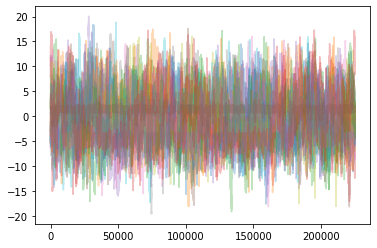

In [28]:
for i in range(16):
    plt.plot(samples_nn_HMC_converge[:,i], alpha = 0.3);

From the plot above we can see that, we have made sure that almost all parameters have converged. Then we plot the picture to visualize the uncertainty:

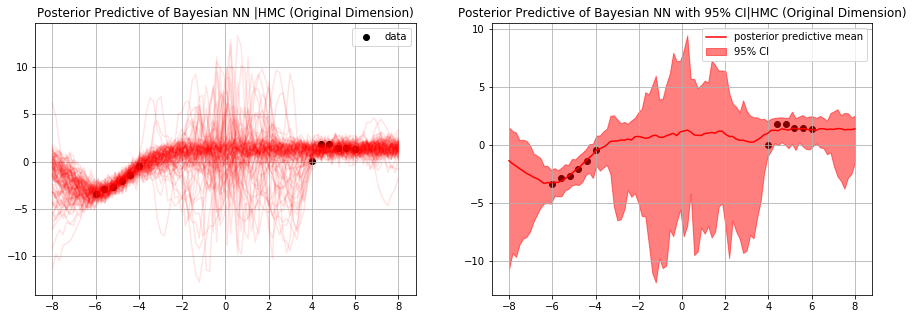

In [40]:
np.random.seed(2019)
n_sample = 100
sample_indices = np.random.choice(np.arange(len(samples_nn_HMC_converge)), n_sample)
sample = samples_nn_HMC_converge[sample_indices]

x_test = np.linspace(-8, 8, 100)
y_test_bnn = nn.forward(sample, x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, 0.5, size = (100, 100))

# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC (Original Dimension)')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC (Original Dimension)')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

From the plots above, we can see that the one from original parameter space has clearly revealed both aleatoric and epistemic uncertainty. 

Comparing with the one we got from subspace inference (especially from the one with PCA subspace), we can see that:</br>
<br>
<br>**A. Inference on subspace has dramatically reduced the computation cost**

|Method|Total (sec)|
|---------------|----------------|
|Random  |644.51|
|PCA  |542.33|
|Curve |507.02|
|Original params space|7038.6|

The table above compares the total sections needed for all methods combined with HMC inference. From the table above we can see that, to achieve a converged status, inference on original parameter space is 12 times larger than inference in subspace.

<br>**B. Inference on subspace also reveals meaningful uncertainty information in visualization**
![Full space comparison](https://i.ibb.co/zQFKS7G/Fullspace.png)


From the plots above we can see that, although subspace inference is still not as good as inference from the original parameter space, both of the plots have clearly revealed both kinds of uncertainties and provided useful information: 
- They have relatively thin uncertainty when there are some data points, where the interval here contains more the aleatoric uncertainty, which is representative of unknowns that could not be reduced by getting more data. 
- By contrast, they have relatively fat uncertainty intervals when there are less data points, representing the epistemic uncertainty. Since we can reduce epistemic uncertainty by getting more data but can not easily tackle with aleatoric uncertainty, we prefer epistemic uncertainty than aleatoric uncertainty.

**Therefore, we can draw the conclusion that the subspace inference methods documented in the paper are all effective and efficient for Bayesian Deep Learning.**

#### 4.3.2. Deep and Wide Neural Networks

The paper states that the neural network itself induces a structured prior distribution over functions, when combined with a vague prior over its parameters. We are curious in the first half of the sentence, where the structure of the network poses some prior beliefs. In this section, we want to see if changing the neural network's structure would cause any difference in subspace inference. We chose to use the random subspace along with conducting HMC inference in the subspace on different neural networks. The baseline, therefore, is going to be subspace inference on the 1-layer-5-unit neural network, which has been presented before. For comparison, we also conduct subspace inference on a 1-layer-30-unit neural network and a 2-layer-5-unit neural network.

##### Structure: layer = 1, width = 5

In [2]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn_1_5 = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn_1_5.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.1166805377315; gradient mag: 164.73210946091572
Iteration 100 lower bound 52.86436046756695; gradient mag: 56.95458639088454
Iteration 200 lower bound 49.42633385370295; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.73326189562313; gradient mag: 18.31175187956584
Iteration 400 lower bound 46.647745693540806; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.88691542805831; gradient mag: 10.503599898310593
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343006; gradient mag: 24.19257532280088
Iteration 800 lower bound 26.97792508592485; gradient mag: 20.354176994190933
Iteration 900 lower bound 24.27836363766573; gradient mag: 18.77912591689822
Iteration 1000 lower bound 22.029867169404945; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.106100408860318; gradient mag: 16.21045518866592
Iteration 1200 lower bound 18.43436747168103; gradient mag: 15.092044558

In [5]:
my_subspace_1_5 = Subspace.create(subspace_type="random", model=my_nn_1_5, n_subspace=2)
my_subspace_1_5.collect_vector(X=x, y=y)
P, w = my_subspace_1_5.get_space()

In [6]:
hmc_tune_params={'step_size':1e-3,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

my_inference_1_5 = Inference.create(inference_type="HMC", model=my_nn_1_5, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn_1_5.get_z_from_W(weights=my_nn_1_5.weights, P=my_inference_1_5.P, w_hat=my_inference_1_5.w_hat)

In [7]:
begin=time.time()
my_inference_1_5.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.001
HMC 400: accept rate of 99.75 with step size 0.002499340131779616
HMC 600: accept rate of 99.83333333333333 with step size 0.003999340131779616
HMC 800: accept rate of 99.625 with step size 0.005498440796089194
HMC 1000: accept rate of 99.7 with step size 0.0069984407960891944
HMC 1200: accept rate of 99.75 with step size 0.008498440796089194
HMC 1400: accept rate of 99.5 with step size 0.009998440796089194
HMC 1600: accept rate of 99.5 with step size 0.011131891850685758
HMC 1800: accept rate of 99.44444444444444 with step size 0.012615511645627075
HMC 2000: accept rate of 99.3 with step size 0.014115511645627075
HMC 2200: accept rate of 99.18181818181819 with step size 0.015615511645627075
HMC 2400: accept rate of 98.95833333333334 with step size 0.017115511645627076
HMC 2600: accept rate of 98.61538461538461 with step size 0.018615511645627077
HMC 2800: accept rate of 98.60714285714286 with step size 0.019954583155066888
HMC 3000: a

In [8]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 5.63 min


In [9]:
# get posterior z
n_sample = 100
post_sample = my_inference_1_5.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn_1_5 = my_nn_1_5.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn_1_5.Sigma_Y_det, size = (100, 100))


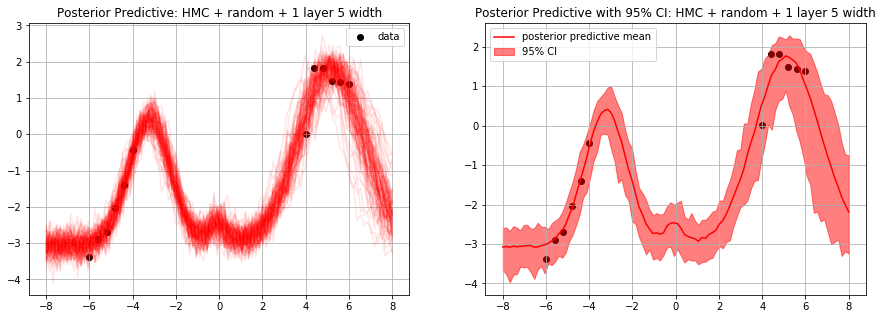

In [10]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive: HMC + random + 1 layer 5 width')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn_1_5[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn_1_5.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn_1_5, 0.25, axis=0), np.percentile(y_test_bnn_1_5, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive with 95% CI: HMC + random + 1 layer 5 width')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

In [11]:
y_pred= my_nn_1_5.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_random = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_random))

The Posterior Predictive Log likelihood of the observed data is -4.4163


##### Structure: layer = 1, width = 30

In [12]:
###neural network model design choices
width = 30
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn_1_30 = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn_1_30.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 32.58793915718334; gradient mag: 94.39143716072499
Iteration 100 lower bound 8.473450997830842; gradient mag: 41.69363082960816
Iteration 200 lower bound 3.6493116898032696; gradient mag: 14.762985279078086
Iteration 300 lower bound 1.8855206455131108; gradient mag: 5.029492342722086
Iteration 400 lower bound 1.3453948601924908; gradient mag: 2.434003197860627
Iteration 500 lower bound 1.075847103012563; gradient mag: 1.6184009486589837
Iteration 600 lower bound 0.8990651351045867; gradient mag: 1.1805931584788822
Iteration 700 lower bound 0.7779115101311369; gradient mag: 0.8918417732253724
Iteration 800 lower bound 0.6911452868762314; gradient mag: 0.6960259361393869
Iteration 900 lower bound 0.6251712278078676; gradient mag: 0.5617487991498086
Iteration 1000 lower bound 0.5720066616921051; gradient mag: 0.4642564214612612
Iteration 1100 lower bound 0.5274133350175305; gradient mag: 0.3873386672660175
Iteration 1200 lower bound 0.48920309157935765; gradient ma

In [13]:
my_subspace_1_30 = Subspace.create(subspace_type="random", model=my_nn_1_30, n_subspace=2)
my_subspace_1_30.collect_vector(X=x, y=y)
P, w = my_subspace_1_30.get_space()

hmc_tune_params={'step_size':1e-2,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

my_inference_1_30 = Inference.create(inference_type="HMC", model=my_nn_1_30, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn_1_30.get_z_from_W(weights=my_nn_1_30.weights, P=my_inference_1_30.P, w_hat=my_inference_1_30.w_hat)


In [14]:
begin=time.time()
my_inference_1_30.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 98.0 with step size 0.01
HMC 400: accept rate of 96.25 with step size 0.011498764726526056
HMC 600: accept rate of 96.0 with step size 0.012998764726526056
HMC 800: accept rate of 94.875 with step size 0.014474686626948705
HMC 1000: accept rate of 94.1 with step size 0.013928640855923616
HMC 1200: accept rate of 93.58333333333333 with step size 0.015428640855923615
HMC 1400: accept rate of 92.71428571428572 with step size 0.016928640855923615
HMC 1600: accept rate of 91.375 with step size 0.017195546842612236
HMC 1800: accept rate of 89.94444444444444 with step size 0.018449418307303626
HMC 2000: accept rate of 86.8 with step size 0.019574376620079263
HMC 2200: accept rate of 86.68181818181819 with step size 0.016877025048833757
HMC 2400: accept rate of 85.20833333333333 with step size 0.018377025048833758
HMC 2600: accept rate of 84.76923076923077 with step size 0.01804237430303004
HMC 2800: accept rate of 83.57142857142857 with step size 0.018806811141484782
H

In [15]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 5.96 min


In [16]:
# get posterior z
n_sample = 100
post_sample = my_inference_1_30.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn_1_30 = my_nn_1_30.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn_1_30.Sigma_Y_det, size = (100, 100))


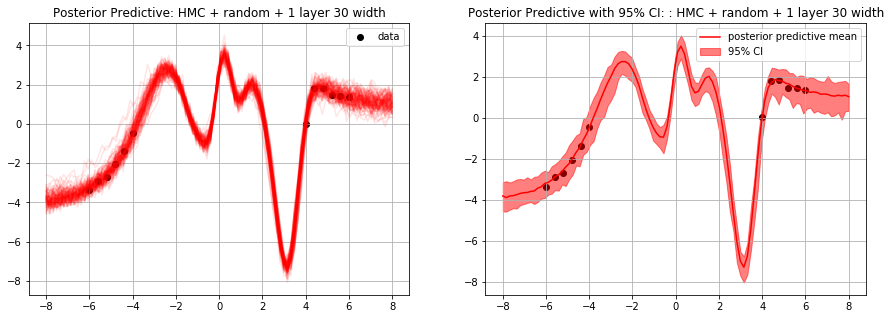

In [17]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive: HMC + random + 1 layer 30 width')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn_1_30[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn_1_30.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn_1_30, 0.25, axis=0), np.percentile(y_test_bnn_1_30, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive with 95% CI: : HMC + random + 1 layer 30 width')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

In [18]:
y_pred= my_nn_1_30.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_random = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_random))

The Posterior Predictive Log likelihood of the observed data is -2.2122


##### Structure: layer = 2, width = 5

In [19]:
###neural network model design choices
width = 5
hidden_layers = 2
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn_2_5 = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn_2_5.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 58.51737965235858; gradient mag: 146.22784407127557
Iteration 100 lower bound 46.58811441002415; gradient mag: 40.140639166229654
Iteration 200 lower bound 44.50828280943876; gradient mag: 17.036262898343303
Iteration 300 lower bound 13.936341003308048; gradient mag: 60.17215353190675
Iteration 400 lower bound 6.7789666426703485; gradient mag: 15.636085842033989
Iteration 500 lower bound 5.291787455219593; gradient mag: 13.931373366657537
Iteration 600 lower bound 4.0765812415145275; gradient mag: 9.457487080045432
Iteration 700 lower bound 3.2905119643969165; gradient mag: 5.376004592445491
Iteration 800 lower bound 2.8225066742216107; gradient mag: 3.643371355531353
Iteration 900 lower bound 2.52621586763896; gradient mag: 2.9279791537402438
Iteration 1000 lower bound 2.3228335679826007; gradient mag: 2.530805273403531
Iteration 1100 lower bound 2.1723846557701085; gradient mag: 2.1395101712264464
Iteration 1200 lower bound 2.0567908655121516; gradient mag: 1.

In [21]:
my_subspace_2_5 = Subspace.create(subspace_type="random", model=my_nn_2_5, n_subspace=2)
my_subspace_2_5.collect_vector(X=x, y=y)
P, w = my_subspace_2_5.get_space()

hmc_tune_params={'step_size':0.005,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.1,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

my_inference_2_5 = Inference.create(inference_type="HMC", model=my_nn_2_5, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn_2_5.get_z_from_W(weights=my_nn_2_5.weights, P=my_inference_2_5.P, w_hat=my_inference_2_5.w_hat)

begin=time.time()
my_inference_2_5.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 98.5 with step size 0.005
HMC 400: accept rate of 98.25 with step size 0.006368964964212175
HMC 600: accept rate of 96.16666666666667 with step size 0.007820082841808327
HMC 800: accept rate of 90.5 with step size 0.009178824522239388
HMC 1000: accept rate of 89.2 with step size 0.009157606535228931
HMC 1200: accept rate of 83.08333333333333 with step size 0.01065760653522893
HMC 1400: accept rate of 79.5 with step size 0.010273389792533503
HMC 1600: accept rate of 73.1875 with step size 0.010273389792533503
HMC 1800: accept rate of 71.0 with step size 0.010273389792533503
HMC 200: accept rate of 67.0
HMC 400: accept rate of 36.5
HMC 600: accept rate of 48.333333333333336
HMC 800: accept rate of 55.0
HMC 1000: accept rate of 61.5
HMC 1200: accept rate of 53.833333333333336
HMC 1400: accept rate of 57.642857142857146
HMC 1600: accept rate of 58.75
HMC 1800: accept rate of 59.55555555555556
HMC 2000: accept rate of 57.8
HMC 2200: accept rate of 57.18181818181818
H

In [22]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 6.45 min


In [23]:
# get posterior z
n_sample = 100
post_sample = my_inference_2_5.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn_2_5 = my_nn_2_5.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn_2_5.Sigma_Y_det, size = (100, 100))



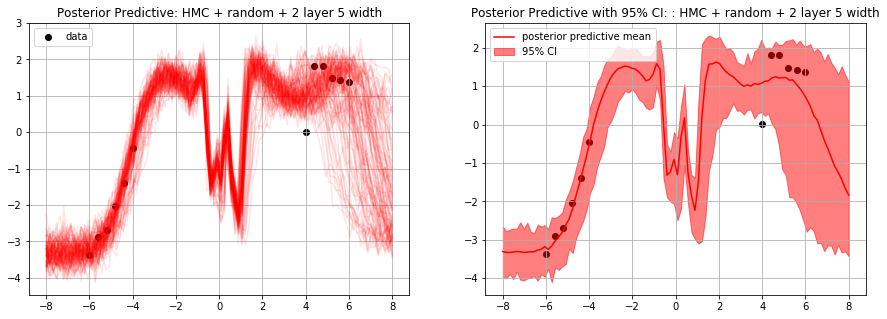

In [24]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive: HMC + random + 2 layer 5 width')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn_2_5[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn_2_5.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn_2_5, 0.25, axis=0), np.percentile(y_test_bnn_2_5, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive with 95% CI: : HMC + random + 2 layer 5 width')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

In [25]:
y_pred= my_nn_2_5.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_random = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_random))

The Posterior Predictive Log likelihood of the observed data is -13.9473


To help us summarize the results, we plot the predictive distributions together for the three network structures.

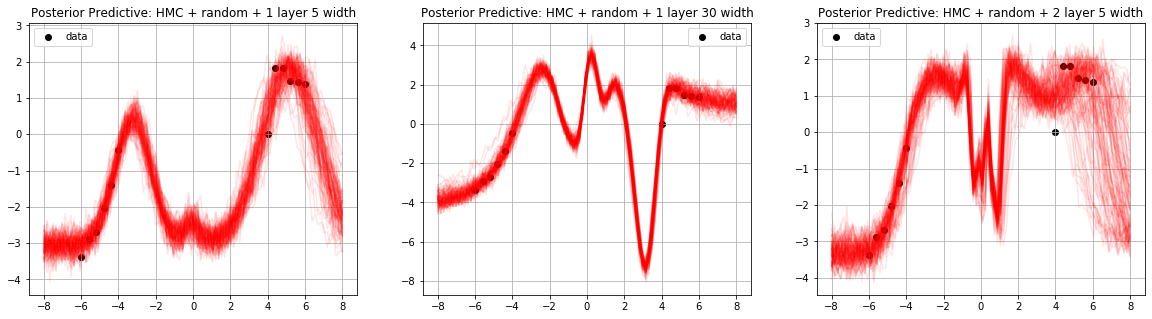

In [28]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.grid()
plt.title('Posterior Predictive: HMC + random + 1 layer 5 width')
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn_1_5[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()

plt.subplot(1, 3, 2)
plt.grid()
plt.title('Posterior Predictive: HMC + random + 1 layer 30 width')
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn_1_30[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()

plt.subplot(1, 3, 3)
plt.grid()
plt.title('Posterior Predictive: HMC + random + 2 layer 5 width')
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn_2_5[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()

Here is the table for comparison of inference time spent and log likelihood.

| Structure        | Inference Time (min) | Log-Likelihood |
|------------------|----------------------|----------------|
| 1 layer 5 units  | 5.63                 | -4.4163        |
| 1 layer 30 units | 5.96                 | -2.2122        |
| 2 layer 5 units  | 6.45                 | -13.9473       |

We choose network structures in the test group because they are not extremely difficult to work with and they have similar dimension of their original parameter space.

From the above information, we observe that:

- The shape of posterior distribution is dependent on the structure of the neural network. The wider or deeper neural networks provide more complicated shapes in their posterior distribution. They tend to suggest more extreme values at the places where no observation data exists.
- The wider network is not significantly harder to conduct inference on, as long as the number of units is reasonable. On the other hand, the deep network is the hardest to perform subspace inference on. We hypothesis that this is the case because deeper networks emcompass more types of models and its posterior log density is the roughest among the three structures. No wonder why the paper references inference with deep neural networks but not wide neural networks.
- Wider networks have smaller uncerntainty nearby the data points, which is the case for the baseline structure, but they also have the smallest uncertainty in between two data clusters. This is not the case for neither the baseline structure and the deep structure. In other words, inference on wider networks exhibits less epistemic uncertainty.
- Wider networks exhibit the highest log-likelihood, while deeper networks have the lowest. This suggests that choosing the right structure of a neural network for a set of data will benefits in increasing the prediction accuracy and lowering the uncertainty. 

From this experiment, we learned that subspace inference is able to capture the nuance among different neural network structures.


#### 4.3.3. Different initialization

Earlier in the discussion, we mentioned the initial weights that are used to construct the right subspace. We wonder how much effect this initial weights have on the final posterior distribution. Will subspace inference still perform strongly with a random initialization? 

Instead of fitting a neural network, we leave it unfitted to the data. We then constructed a random subspace and conducted BBB on the subspace.

In [2]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# # use MSE result as params_init
# params = {'step_size':1e-3, 
#           'max_iteration':5000, 
#           'random_restarts':1}

# # fit my neural network to minimize MSE on the given data
# my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

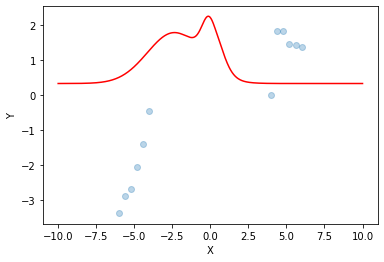

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y');

In [5]:
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [6]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [7]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -117.64317843182843; gradient mag: 33.082620192107726
Iteration 200 lower bound -98.53447484127449; gradient mag: 8.841611834679311
Iteration 400 lower bound -95.18334931404696; gradient mag: 4.001006145865893
Iteration 600 lower bound -93.9932114724226; gradient mag: 2.5857896300407384
Iteration 800 lower bound -93.42962122414335; gradient mag: 1.643883230694722
Iteration 1000 lower bound -93.10151400722609; gradient mag: 1.014634512206945
Iteration 1200 lower bound -92.98439983140786; gradient mag: 0.7564436975891048
Iteration 1400 lower bound -92.89398012217498; gradient mag: 0.7529320169274091
Iteration 1600 lower bound -92.91923439850359; gradient mag: 0.29197875146397806
Iteration 1800 lower bound -92.84485163450779; gradient mag: 0.4731938839912986
Iteration 2000 lower bound -92.85317210064412; gradient mag: 0.6149042564609141
Iteration 2200 lower bound -92.84137021067963; gradient mag: 0.278423860645062
Iteration 2400 lower bound -92.86399831792636; grad

In [8]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 9.41 min


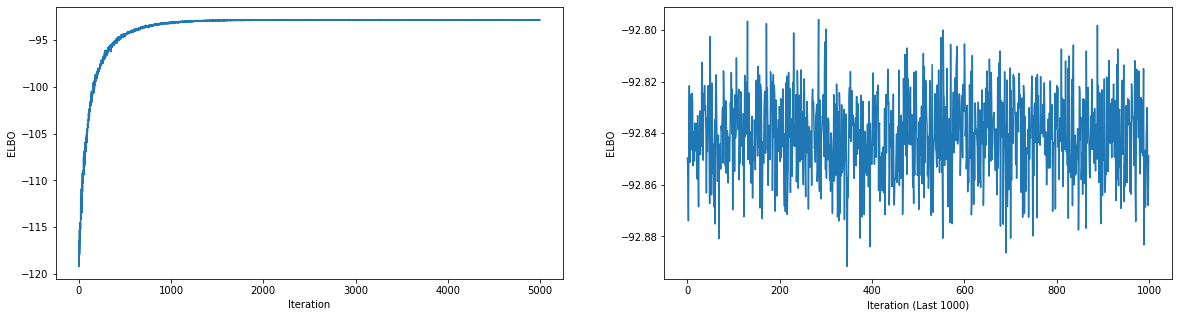

In [9]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(my_inference.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(my_inference.ELBO[-1000:])
ax[1].set_xlabel('Iteration (Last 1000)')
ax[1].set_ylabel('ELBO');

In [10]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

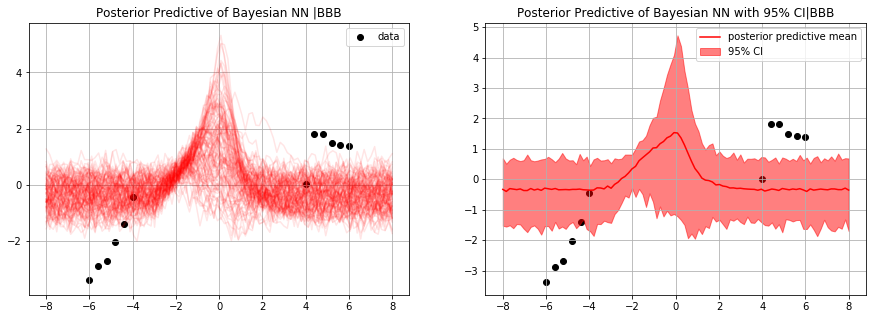

In [11]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

We quickly conclude that random initialization would hurt the performance of subspace inference. This is as what we  expected. The subspace construction relies on the pre-trained solution. 

**We conclude that subspace inference can only be done after the neural network fits the data.**

#### 4.3.4. PCA variant
In the paper, the deviation matrix is updated during equal epoch intervals. However, to construct a more precise subspace, it's natural for us to have the hypothesis that forming the projection matrix $P$ with the PCA component of the smallest deviation could be better than that of the equal-interval deviations. 

To formulate the hypothesis, we define the expressions as follows:
<br>$w0$: pretrained weights;
<br>$\eta$: learning rate;
<br>$T$: number of steps;
<br>$c$: moment update frequency;
<br>$M$: maximum number of columns in deviation matrix;
<br>$K$: rank of PCA approximation;
<br>$A$: deviation matrix;
<br>$P$: projection matrix for subspace


The original algorithm to construct subspace with PCA goes as follows:

<p style="text-align: right">step0 [Initialize mean] </p>
<br>$w_{SWA} \leftarrow w_0$
<p style="text-align: right">step1 [SGD Update]</p>
<br>for $i\leftarrow1,2,\cdots, T \text{ do}$
<br>$\quad$ $w_i \leftarrow w_{i-1} - \eta \nabla_{w}\mathcal{L}(w_{i-1})$
<p style="text-align: right">step2 [SWA Update]</p>
<br>$\quad$ if MOD$(i,c)=0$ then
<br>$\quad\quad$ $n\leftarrow i/c$
<br>$\quad\quad$ $w_{SWA}\leftarrow \frac{nw_{SWA} + w_i}{n+1}$
<p style="text-align: right">step3 [devation matrix Update]</p>
<br>$\quad\quad$ if NUM_COLS($A$) = $M$ then
<br>$\quad\quad\quad$ REMOVE_COL($A$[:,1])
<br>$\quad\quad$ APPEND_COLS($A$, $w_i - \bar{w}$)
<p style="text-align: right">step4 [Truncated SVD]</p>
<br>$U,S,V^{T}\leftarrow SVD(A)$
<br>return $\hat{w} = w_{SWA}$, $P = SV^T$

In our algorithm, we construct the deviation matrix with the smallest $M$ deviations. The main difference betweem our algorithm and the paper lies in step3 (deviation matrix update process). One difficulty in our algorithm is how to find the minimum $M$ deviations with an efficient use of memory. That is to say, if we first store all possible devations in a matrix and then pick the smallest deviations, there will be a high demand for memory which makes our algorithm hard to scale up. Therefore, we come up with a training in on-line fashion, that is to construct a matrix which stores the smallest $M$ deviations so far and keep updating the matrix when new deviations come in. Under this method, the maximum of the use of memory is $M$, which is the same as theirs. To be more specific, our algorithm goes as below:
<p style="text-align: right">step0 [Initialize mean] </p>
<br>$w_{SWA} \leftarrow w_0$
<p style="text-align: right">step1 [SGD Update]</p>
<br>for $i\leftarrow1,2,\cdots, T \text{ do}$
<br>$\quad$ $w_i \leftarrow w_{i-1} - \eta \nabla_{w}\mathcal{L}(w_{i-1})$
<p style="text-align: right">step2 [SWA Update]</p>
<br>$\quad$ if MOD$(i,c)=0$ then
<br>$\quad\quad$ $n\leftarrow i/c$
<br>$\quad\quad$ $w_{SWA}\leftarrow \frac{nw_{SWA} + w_i}{n+1}$
<p style="text-align: right"><b>step3 [devation matrix Update]</b></p>
<br>$\quad\quad$ if NUM_COLS($A$) = $M$ then
<br>$\quad\quad\quad$ if norm($w_i - \bar{w}$) < norm(A[:,-1]) then
<br>$\quad\quad\quad\quad$ REMOVE_COL($A$[:,-1])
<br>$\quad\quad\quad\quad$ APPEND_COLS($A$, $w_i - \bar{w}$)
<br>$\quad\quad\quad\quad$ SORT_BY_NORM($A$, ascending=True)
<br>$\quad\quad$ else:
<br>$\quad\quad\quad$ APPEND_COLS($A$, $w_i - \bar{w}$)
<br>$\quad\quad\quad$ SORT_BY_NORM($A$, ascending=True)
<p style="text-align: right">step4 [Truncated SVD]</p>
<br>$U,S,V^{T}\leftarrow SVD(A)$
<br>return $\hat{w} = w_{SWA}$, $P = SV^T$

In [22]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y, method='S') # chose the method as L
P, w = my_subspace.get_space()

In [23]:
hmc_tune_params={'step_size':5e-2,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

In [24]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=5)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)


In [25]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.05
HMC 400: accept rate of 100.0 with step size 0.05149605792925664
HMC 600: accept rate of 100.0 with step size 0.05299605792925664
HMC 800: accept rate of 99.875 with step size 0.054496057929256644
HMC 1000: accept rate of 99.8 with step size 0.055996057929256646
HMC 1200: accept rate of 99.83333333333333 with step size 0.0574947659062378
HMC 1400: accept rate of 99.85714285714286 with step size 0.05898888637377429
HMC 1600: accept rate of 99.875 with step size 0.06048835268356851
HMC 1800: accept rate of 99.8888888888889 with step size 0.06198835268356851
HMC 2000: accept rate of 99.9 with step size 0.0634883526835685
HMC 2200: accept rate of 99.90909090909092 with step size 0.06497280104637061
HMC 2400: accept rate of 99.91666666666667 with step size 0.06647280104637061
HMC 2600: accept rate of 99.92307692307692 with step size 0.06796592043713326
HMC 2800: accept rate of 99.92857142857143 with step size 0.06946380836921373
HMC 3000: ac

In [26]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 10.91 min


In [27]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

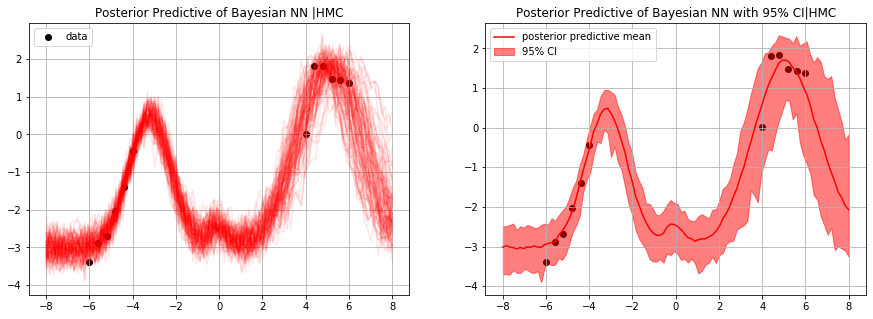

In [28]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

We also plotted the traceplots to check the convergence.

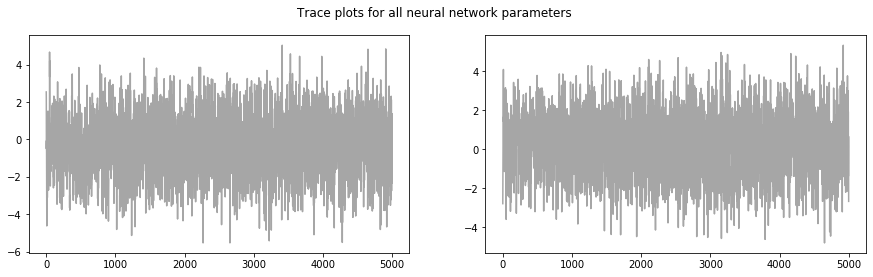

In [29]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

From the traceplot above, it seems that the HMC sampler has already converged.

In [30]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca_smallest = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca_smallest))

The Posterior Predictive Log likelihood of the observed data is -4.7667


From the test statistics above we can see that PCA with our extension of the smallest deviations (log likelihood: -4.7667) does the job as well as the PCA with equal interval published in the paper (log likelihood: -4.3521). However from the posterior predictive plots above, PCA with equal interval is more informative. We also tested it with BBB sampler and gets a similar result with a pretty good log likelihood (-2.9177) but a quite un-informative uncertainty visualization plot:

![pca_smallest](https://i.ibb.co/92VYMCy/pca-smallest-BBB.png)

After careful analysis, we think this phenomenon is due to the fact that the deviation matrix actually contains little useful information in constructing the subspace. Following this analysis, PCA with largest deviations would also do a bad job in revealing the uncertainty but in an opposite way: it will widen the uncertainty bound as it captures more unrelevant information in constructing subspace by constrast. The experiment results below strongly support our hypothesis.

![pca_smallest](https://i.ibb.co/mb817dM/pca-largest.png)



**From the exploration of PCA variants we have deepened our understanding in how the deviation matrix affects the uncertaintly visualization at the end.**
- If the matrix contains little useful information, it will give a conservative picture of the uncertainty. Specifically, it prones to provide a narrower uncertainty boundary and does not distinguish the 2 kinds of uncertainties clearly.
- If the matrix contains much unrelevant information, it will overestimate the uncertainty and widen the uncertainty boundary inappropriately.

Therefore, the size of the norm in deviation matrix is not the key to improve the PCA performance. What might be promising is to take snapshot of every local minima of the weights and record its corresponding deviation. 

## 5. Future Work

1. From the analysis in **4.3.4. PCA variant**, we believe that instead of take every T steps of the weights, taking snapshot of every local minima of the weights and record its corresponding deviation to update the deviation matrix could be promising in improving the performance. 
2. Theoretically prove that all the models that fit the data lies in a subspace.
3. Find a subspace in between PCA and curve subspace, that is easier to construct than curve subspace, but contains more information about the good models than PCA. 